# WeaveForward — Fiber–Artisan Match Pipeline & Recommendation Model

| Step | Notebook | Purpose | Output |
|------|----------|---------|--------|
| 1 | `webscraper_extraction.ipynb` | Scrape PH + multinational brand sites, parse `fiber_json` compositions, compute biodeg tiers | `data/webscraped_data/YYYYMMDD-HHMMSS-webscraped_catalog.csv` |
| 2 | **`fiber_recommendation_model.ipynb`** ← *this file* | Load scraper CSV → NCR geocoded donor requests (Nominatim OSM) → Spark ETL + biodeg UDFs → `_FIBERS_OF_INTEREST` derived from `brand_fiber_lookup.json` → donation × artisan pair matrix → binary `is_match` CatBoost classifier → Seaborn visualizations → Django API artifact export | `models/catboost_fiber_match.cbm`, `data/processed/fiber_match_ranked_latest.csv`, visualizations |

> **Run order:** `webscraper_extraction.ipynb` → this notebook.
>
> **Target variable:** `is_match` — binary `1 = match / 0 = no_match`  
> A donation **matches** an artisan when: (1) the garment's dominant accepted fiber ≥ 30 % of composition, (2) biodeg score ≥ artisan's minimum threshold, and (3) donor location is within the artisan's collection radius. The model learns from continuous signals (`pct_target_fiber`, `distance_km`, `biodeg_score`, per-fiber `pct_*` columns) — the hard thresholds are only used to generate training labels.
>
> **Fiber vocabulary** is dynamically derived at runtime: `_FIBERS_OF_INTEREST = scraped brand fibers ∩ fibers present in donor data`. Per-garment `pct_*` columns are always live from `fiber_json` in the scraped CSV — no hardcoded composition values.
>
> **Django REST API** (`WeaveForward_Recommendation_API/`) is a standalone project on disk.  
> Set `DJANGO_ML_DIR=/path/to/weaveforward_api/ml_artifacts` in `.env` before running cell 51 (8-D), which copies the trained model, metadata, and ranked predictions to that directory. Then run `python manage.py runserver` from the API project folder.
>
> **⚠ Synthetic data notice:** Artisan business profiles (names, coordinates, fiber preferences, thresholds) are **fabricated for development and testing only**. They do not represent real businesses. Replace `ARTISAN_REGISTRY` in cell 35 with a live database or API query before production deployment.
>
> **Note:** For the testing environment, only **2 PH + 2 multinational brand sites** were used to keep scraping time manageable during development.


---
## 0 · Environment Setup

In [81]:
import subprocess, sys

PACKAGES = [
    # Spark
    "pyspark",
    "delta-spark",
    # ML / Eval
    "catboost",
    "optuna",
    "scikit-learn",
    "shap",
    # Visualization / Utils
    "matplotlib",
    "seaborn",
    "tqdm",
    "python-dotenv",
    "numpy",
    "pandas",
    "pyarrow",
    # Geocoding
    "geopy",
    "requests",
]

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *PACKAGES])

import os
from pathlib import Path

ROOT       = Path("..").resolve()
DATA_DIR   = ROOT / "data"
WEB_DIR    = DATA_DIR / "webscraped_data"
PROC_DIR   = DATA_DIR / "processed"
MODEL_DIR  = ROOT / "models"
SPARK_WH   = DATA_DIR / "spark_warehouse"
VIZ_DIR    = DATA_DIR / "visualizations"

for d in [WEB_DIR, PROC_DIR, MODEL_DIR, SPARK_WH, VIZ_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("✓ environment ready")


✓ environment ready



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


---
## 1 · Imports & Global Config

In [82]:
import numpy as np
import pandas as pd
import json, re, uuid, time, random, logging, glob, shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import optuna
import shap
import requests

from pathlib     import Path
from datetime    import datetime
from tqdm        import tqdm
from dotenv      import load_dotenv
from geopy.geocoders         import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# PySpark
from pyspark.sql        import SparkSession
from pyspark.sql        import functions as F
from pyspark.sql.types  import (StructType, StructField, StringType,
                                 DoubleType, IntegerType, BooleanType)

# ML
from catboost        import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)

load_dotenv()
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✓ imports ready")


✓ imports ready


In [83]:
# ── Visualization theme & color palette ──────────────────────────────────
EARTH = ["#5c4a2a", "#7a6040", "#9b7d54", "#b89a6e", "#d4b896",
         "#8b6914", "#6b8e23", "#4a7c59", "#2d6a4f", "#1b4332"]
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 130, "figure.figsize": (12, 5)})

# ── Stable overwriting visualization path ─────────────────────────────────
def viz_path(stem: str) -> Path:
    """Return VIZ_DIR/<stem>.png — file is overwritten on every run."""
    return VIZ_DIR / f"{stem}.png"

print(f"✓ viz_path() ready  —  output dir : {VIZ_DIR}")

✓ viz_path() ready  —  output dir : /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations


### Biodegradability Score Reference & Methodology

`BIODEG_SCORES` assigns each fiber a **normalized 0–100 composite score** representing its relative rate and completeness of biodegradation under typical environmental conditions (soil burial / composting / marine). Three fibers are **directly anchored** to measured % degradation values from Zambrano et al. (2019); all remaining fibers are calibrated on the same scale using peer-reviewed literature.

| Tier | Score range | Fibers | Basis |
|------|-------------|--------|-------|
| High | 91–96 | linen, hemp, cotton, lyocell/Tencel | Near-complete cellulosic degradation within weeks–months; lyocell NMMO process measured ~87 % at 28 d marine |
| Medium-high | 72–83 | silk, wool, cashmere, bamboo, modal, rayon, viscose, denim | Protein fibers (keratin/fibroin) or regenerated cellulosics; slower kinetics or chemical processing reduces rate |
| Low | 4–12 | nylon, polyester, acrylic, elastane, spandex, lycra | Petroleum-based synthetics; persist decades–centuries in the environment |
| Default | 30 | unknown | Conservative midpoint for fibers with no identified composition |

**Key references:**

1. Textile Exchange. (2022). *Preferred Fiber & Materials Market Report 2022*. [https://textileexchange.org/app/uploads/2022/10/Textile-Exchange_PFMR_2022.pdf](https://textileexchange.org/app/uploads/2022/10/Textile-Exchange_PFMR_2022.pdf)

2. Zambrano, M.C., Pawlak, J.J., Daystar, J., Ankeny, M., Cheng, J.J., & Venditti, R.A. (2019). Microfibers generated from the laundering of cotton, rayon and polyester based fabrics and their aquatic biodegradation. *Marine Pollution Bulletin*, 142, 394–407. [https://doi.org/10.1016/j.marpolbul.2019.02.062](https://doi.org/10.1016/j.marpolbul.2019.02.062)

3. Henry, B., Laitala, K., & Klepp, I.G. (2019). Microfibres from apparel and home textiles: Prospects for including microplastics in environmental sustainability assessment. *Science of The Total Environment*, 652, 483–494. [https://doi.org/10.1016/j.scitotenv.2018.10.166](https://doi.org/10.1016/j.scitotenv.2018.10.166)

4. Andrady, A.L. (2011). Microplastics in the marine environment. *Marine Pollution Bulletin*, 62(8), 1596–1605. [https://doi.org/10.1016/j.marpolbul.2011.05.030](https://doi.org/10.1016/j.marpolbul.2011.05.030)

5. Muthu, S.S. (2014). *Assessing the Environmental Impact of Textiles and the Clothing Supply Chain*. Woodhead Publishing. ISBN 978-0-85709-433-4.

6. WRAP. (2017). *Valuing Our Clothes: the cost of UK fashion*. [https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf](https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf)

> **`BIO_FIBERS`** lists fibers classified as *natural or bio-based cellulosic*, consistent with Textile Exchange preferred fiber categories. Acetate and denim are included as cellulose derivatives despite chemical processing.

---

#### Empirical Anchoring & Derivation Notes

**Three primary anchor points** are taken directly from **Zambrano et al. (2019)** [ref. 2], which measured aquatic biodegradation of microfibers in seawater over 90 days:

| Anchor fiber | Measured % degradation (90 d seawater) | Score |
|-------------|----------------------------------------|-------|
| cotton | ~74 % | 92 |
| rayon | ~60 % | 72 |
| polyester | ~2 % | 8 |

The 0–100 scale is stretched upward for non-seawater conditions (soil burial / composting degrade cellulosics faster than seawater), hence cotton scores 92 rather than 74.

**Remaining fibers calibrated on the same scale:**
- **Lyocell / Tencel (91)**: NMMO closed-loop process leaves cellulose highly accessible; measured ~87 % marine degradation at 28 days — *faster* than cotton at the same timepoint.
- **Silk (83)**: Silk fibroin degrades faster than keratin (wool) but slower than cellulosics; silk suture studies document significant degradation within weeks in tissue/soil environments.
- **Wool / Cashmere (74)**: Keratin protein; soil burial studies document 50–70 % weight loss after 6 months — slower than any cellulosic fiber. Cashmere shares near-identical protein structure.
- **Bamboo (73)**: Apparel-grade bamboo is virtually always bamboo viscose — the same alkaline/CS₂ chemical process as rayon — giving it rayon-equivalent degradation kinetics.
- **Modal (76)**: Beech-wood viscose derivative; intermediate between rayon (72) and lyocell (91) reflecting its partially retained crystallinity.
- **Synthetics (4–12)**: Andrady (2011) [ref. 4] documents quantified persistence timescales of 20–500+ years for petroleum-based polymers in marine environments.

For the closest available **published numeric scoring systems**, see:

**Sustainable Apparel Coalition — Higg Materials Sustainability Index (MSI)**  
Industry-standard LCA-based tool assigning numeric environmental impact scores per kg of fiber.  
→ [https://apparelcoalition.org/higg-msi/](https://apparelcoalition.org/higg-msi/)

**MADE-BY Environmental Benchmark for Fibres**  
Assigns A–E environmental grades per fiber; natural cellulosics occupy class A–B, synthetics class E.  
→ [http://www.made-by.org/consultancy/tools/environmental-benchmark/](http://www.made-by.org/consultancy/tools/environmental-benchmark/)


In [84]:
# ── Biodegradability reference scores ────────────────────────────────────
# Anchor fibers (Zambrano et al. 2019, seawater 90-day measured % degradation):
#   cotton  ~74 % → 92   rayon   ~60 % → 72   polyester ~2 % → 8
# Remaining fibers calibrated on the same scale using peer-reviewed literature
# (soil burial, composting, and marine degradation studies).
BIODEG_SCORES = {
    # ── Natural cellulosics ─────────────────────────────────────────────
    "cotton":    92,   # Zambrano 2019 anchor; near-complete in composting
    "linen":     95,   # Flax cellulose; complete soil degradation in weeks–months
    "hemp":      96,   # Fastest plant-fiber degradation; looser lignocellulosic structure
    "denim":     78,   # Cotton-based but dye, sizing, tight weave slow rate

    # ── Regenerated cellulosics ─────────────────────────────────────────
    "tencel":    91,   # ↑ from 87; NMMO process → ~87 % marine degradation at 28 d
    "lyocell":   91,   # = Tencel (same NMMO closed-loop process)
    "modal":     76,   # ↓ from 80; beech-wood viscose — intermediate rayon↔lyocell
    "bamboo":    73,   # ↓ from 85; bamboo viscose = rayon-equivalent chemistry
    "rayon":     72,   # Zambrano 2019 anchor; ~60 % seawater 90 d
    "viscose":   72,   # = rayon

    # ── Protein fibers ──────────────────────────────────────────────────
    "silk":      83,   # ↓ from 88; fibroin degrades faster than keratin, slower than cellulosics
    "wool":      74,   # ↓ from 90; keratin — 50–70 % weight loss in 6-month soil burial
    "cashmere":  74,   # ↓ from 89; fine wool protein, near-identical kinetics to wool
    "alpaca":    73,   # Fine camelid keratin; soil burial ~50–65 % at 6 months (≈ wool)

    # ── Petroleum-based synthetics ──────────────────────────────────────
    "nylon":     12,   # Persist decades; some studies 5–15 % degradation at 1 yr
    "polyester":  8,   # Zambrano 2019 anchor; ~2 % seawater 90 d
    "acrylic":    5,   # Similar to or slower than polyester
    "elastane":   4,   # Very persistent; negligible measured degradation
    "spandex":    4,   # = elastane
    "lycra":      4,   # = elastane

    # ── Unknown ─────────────────────────────────────────────────────────
    "unknown":   30,   # Conservative midpoint; no identified composition
}

BIO_FIBERS = frozenset([
    "cotton", "linen", "hemp", "wool", "silk",
    "bamboo", "tencel", "lyocell", "modal",
    "cashmere", "viscose", "rayon", "acetate", "denim",
    "alpaca",   # camelid protein fiber — biodegradable
])

print(f"✓ BIODEG_SCORES ({len(BIODEG_SCORES)} fibers) and BIO_FIBERS ({len(BIO_FIBERS)} fibers) ready")


✓ BIODEG_SCORES (21 fibers) and BIO_FIBERS (15 fibers) ready


In [85]:
# ── Donation decision label encoding ─────────────────────────────────────
# accept     : bio_share ≥ 70 % and biodeg_score ≥ 75
# conditional: bio_share 40–69 % or biodeg_score 50–74
# decline    : bio_share < 40 % or biodeg_score < 50
DECISION_ENCODE = {"accept": 2, "conditional": 1, "decline": 0}
DECISION_DECODE = {2: "accept", 1: "conditional", 0: "decline"}

print("✓ DECISION_ENCODE / DECODE ready:", DECISION_ENCODE)


✓ DECISION_ENCODE / DECODE ready: {'accept': 2, 'conditional': 1, 'decline': 0}


In [86]:
def compute_biodeg_score(fiber_json_str: str) -> float:
    """Weighted-average biodegradability score for a fiber composition JSON string."""
    try:
        fibers = json.loads(fiber_json_str or "{}")
        total  = sum(fibers.values())
        if total == 0:
            return 30.0
        return round(sum(BIODEG_SCORES.get(k.lower(), 30) * v
                         for k, v in fibers.items()) / total, 2)
    except Exception:
        return 30.0


print("✓ compute_biodeg_score() ready")

✓ compute_biodeg_score() ready


In [87]:
def compute_bio_share(fiber_json_str: str) -> float:
    """Percentage of bio/natural fibers in a fiber composition JSON string."""
    try:
        fibers = json.loads(fiber_json_str or "{}")
        total  = sum(fibers.values())
        if total == 0:
            return 0.0
        return round(sum(v for k, v in fibers.items()
                         if k.lower() in BIO_FIBERS) / total * 100, 2)
    except Exception:
        return 0.0


print("✓ compute_bio_share() ready")

✓ compute_bio_share() ready


In [88]:
def donation_decision(bio_share: float, biodeg_score: float) -> str:
    """Map bio_share % and biodeg_score to a donation decision label."""
    if bio_share >= 70 and biodeg_score >= 75:
        return "accept"
    if bio_share >= 40 or biodeg_score >= 50:
        return "conditional"
    return "decline"


print("✓ donation_decision() ready")

✓ donation_decision() ready


---
## 2 · Spark Session

In [89]:
import os, sys

# ── Pin Spark worker Python to the same interpreter as the driver ─────────
os.environ["PYSPARK_PYTHON"]        = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (
    SparkSession.builder
    .appName("WeaveForward_FiberClassificationML")
    .config("spark.sql.warehouse.dir",        str(SPARK_WH))
    .config("spark.sql.shuffle.partitions",   "8")
    .config("spark.driver.memory",            "4g")
    .config("spark.sql.extensions",
            "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog",
            "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .master("local[*]")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

print("  Spark version :", spark.version)
print("  Python (driver/worker):", sys.executable)
print("  Warehouse dir :", SPARK_WH)
print("  Views         : temporary (no persistent database)")
print("✓ Spark session ready")

  Spark version : 4.1.1
  Python (driver/worker): /opt/homebrew/opt/python@3.11/bin/python3.11
  Warehouse dir : /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/spark_warehouse
  Views         : temporary (no persistent database)
✓ Spark session ready


26/02/25 16:05:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


---
## 3 · Load Webscraper Catalog

Reads `data/webscraped_data/webscraped_catalog.csv` produced by
`webscraper_extraction.ipynb`, loads it into a Spark temporary view,
and previews the first 10 rows.


In [90]:
# ── 3-A  Find the most recent timestamped CSV (or stable alias) ───────────
def _latest_catalog() -> Path:
    ts_files = sorted(WEB_DIR.glob("*-webscraped_catalog.csv"), reverse=True)
    if ts_files:
        return ts_files[0]
    stable = WEB_DIR / "webscraped_catalog.csv"
    if stable.exists():
        return stable
    raise FileNotFoundError(
        "No webscraped_catalog.csv found in data/webscraped_data/.\n"
        "Run webscraper_extraction.ipynb first."
    )

catalog_path = _latest_catalog()
print(f"Loading: {catalog_path.name}")

df_catalog = pd.read_csv(catalog_path, encoding="utf-8", low_memory=False)

# ── ensure required computed columns exist ───────────────────────────────
if "fs_bio_share" not in df_catalog.columns:
    df_catalog["fs_bio_share"] = df_catalog["fiber_json"].apply(compute_bio_share)
if "fs_biodeg_score" not in df_catalog.columns:
    df_catalog["fs_biodeg_score"] = df_catalog["fiber_json"].apply(compute_biodeg_score)
df_catalog["fs_biodeg_score"] = pd.to_numeric(
    df_catalog.get("fs_biodeg_score"), errors="coerce").fillna(30.0)
df_catalog["fs_bio_share"]    = pd.to_numeric(
    df_catalog["fs_bio_share"], errors="coerce").fillna(0.0)
df_catalog["fs_biodeg_tier"]  = df_catalog.get(
    "fs_biodeg_tier", pd.Series(["low"] * len(df_catalog)))

# ── load into Spark ───────────────────────────────────────────────────────
df_spark_catalog = spark.createDataFrame(
    df_catalog.fillna({"brand": "unknown", "most_dominant_fiber": "unknown",
                       "clothing_type": "unknown", "source": "unknown",
                       "country_of_brand": "unknown"})
)
df_spark_catalog.createOrReplaceTempView("catalog")

print(f"✓ catalog view created — {df_spark_catalog.count():,} rows, "
      f"{len(df_spark_catalog.columns)} columns")
print(f"  {df_catalog['brand'].nunique()} brands | "
      f"{(df_catalog['source'] == 'philippine').sum()} PH / "
      f"{(df_catalog['source'] == 'multinational').sum()} multinational rows")
print()
print("── First 10 rows preview ───────────────────────────────────────────")
display(df_catalog[[
    "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "fs_biodeg_tier", "source", "country_of_brand"
]].head(10))


Loading: 20260224-212202-webscraped_catalog.csv
✓ catalog view created — 71 rows, 14 columns
  4 brands | 51 PH / 20 multinational rows

── First 10 rows preview ───────────────────────────────────────────


,brand,clothing_type,most_dominant_fiber,fs_bio_share,fs_biodeg_tier,source,country_of_brand
0,Penshoppe,dress,polyester,35.0,low,philippine,PH
1,Penshoppe,dress,cotton,100.0,high,philippine,PH
2,Penshoppe,dress,polyester,35.0,low,philippine,PH
3,Penshoppe,dress,polyester,35.0,low,philippine,PH
4,Penshoppe,dress,polyester,0.0,low,philippine,PH
5,Penshoppe,dress,cotton,100.0,high,philippine,PH
6,Penshoppe,dress,polyester,0.0,low,philippine,PH
7,Penshoppe,dress,polyester,0.0,low,philippine,PH
8,Penshoppe,dress,cotton,60.0,medium,philippine,PH
9,Penshoppe,dress,polyester,0.0,low,philippine,PH


---
## 4 · NCR Donor Request Geocoding (Nominatim OSM)

Fetches real Metro Manila city coordinates from the **Nominatim OpenStreetMap API**,
then assigns webscraped catalog rows to random NCR coordinates as simulated donor
requests. Each city gets a `demand_index` — the **normalized frequency of textile
donation requests** originating from that city (higher = more requests / greater need) for **testing purposes only**.


#### `demand_index` — Definition & Noise Disclaimer

`demand_index` is a **0–1 normalized proxy for the per-city frequency of textile donation requests**: a value of `1.0` represents the highest-demand city in Metro Manila; `0.0` would represent zero demand. Base values are hand-coded from publicly available NCR population density, poverty incidence, and textile charity activity estimates (see `NCR_CITIES_DEMAND_META`).

> **Noise injection (anti-bias measure)**  
> Because every scraped catalog row assigned to the same city would otherwise receive an *identical* `demand_index`, the model could learn to use city membership as a deterministic proxy for the target label — introducing data leakage and positional bias. To prevent this, each donor row receives an independent **Gaussian perturbation** (`σ = 0.04`) added to the city base value, clamped to `[0.0, 1.0]`. This preserves the city-level relative ordering while ensuring no two rows in the same city share the exact same feature value, making `demand_index` a continuous, noisy signal.


In [44]:
# ── 4-A  Fetch real NCR city coordinates via Nominatim OSM ───────────────
# Nominatim usage policy: 1 request/sec, user-agent required.
#
# Fields per city:
#   region          varchar(50)   — always "NCR"
#   city            varchar(50)   — city / municipality name
#   barangay        varchar(50)   — representative barangay
#   latitude        DECIMAL(18,15)
#   longitude       DECIMAL(18,15)
#   display_address varchar(225)  — "Barangay, City, NCR, Philippines"

NCR_CITIES_DEMAND_META = {
    # city: (demand_index 0-1, representative_barangay)
    "Manila":         (0.95, "Ermita"),
    "Quezon City":    (0.88, "Diliman"),
    "Caloocan":       (0.80, "Bagong Silang"),
    "Las Piñas":      (0.65, "Almanza Uno"),
    "Makati":         (0.72, "Bel-Air"),
    "Malabon":        (0.78, "Acacia"),
    "Mandaluyong":    (0.70, "Wack-Wack Greenhills"),
    "Marikina":       (0.68, "Concepcion Uno"),
    "Muntinlupa":     (0.60, "Alabang"),
    "Navotas":        (0.82, "Northbay Boulevard Norte"),
    "Parañaque":      (0.67, "BF Homes"),
    "Pasay":          (0.75, "Malibay"),
    "Pasig":          (0.69, "Kapitolyo"),
    "Pateros":        (0.55, "San Pedro"),
    "San Juan":       (0.58, "Greenhills"),
    "Taguig":         (0.62, "Bonifacio Global City"),
    "Valenzuela":     (0.73, "Karuhatan"),
}

geolocator = Nominatim(user_agent="fiber_recommendation_model/1.0")
geocode    = RateLimiter(geolocator.geocode, min_delay_seconds=1.1)

city_coords: dict[str, dict] = {}
failed:      list[str]       = []

print("Geocoding NCR cities via Nominatim OSM …")
for city, (demand_idx, barangay) in tqdm(NCR_CITIES_DEMAND_META.items(), desc="Nominatim"):
    try:
        loc = geocode(f"{city}, Metro Manila, Philippines")
        if loc:
            city_coords[city] = {
                "region":          "NCR",
                "city":            city,
                "barangay":        barangay,
                "latitude":        round(loc.latitude,  15),
                "longitude":       round(loc.longitude, 15),
                "demand_index":    demand_idx,
                "display_address": f"{barangay}, {city}, NCR, Philippines",
            }
        else:
            failed.append(city)
            print(f"  ✗ {city}: no result returned by Nominatim")
    except Exception as e:
        failed.append(city)
        print(f"  ✗ {city}: {e}")

if failed:
    raise RuntimeError(
        f"Nominatim geocoding failed for {len(failed)} cities: {failed}\n"
        "Check your internet connection or Nominatim rate-limit"
    )

print(f"\n✓ {len(city_coords)} / {len(NCR_CITIES_DEMAND_META)} NCR cities geocoded from OSM")
for city, d in city_coords.items():
    print(f"  {city:<18} lat={d['latitude']:.6f}  lon={d['longitude']:.6f}"
          f"  demand={d['demand_index']}  barangay={d['barangay']}")


Geocoding NCR cities via Nominatim OSM …


Nominatim: 100%|██████████| 17/17 [00:17<00:00,  1.06s/it]


✓ 17 / 17 NCR cities geocoded from OSM
  Manila             lat=14.590449  lon=120.980362  demand=0.95  barangay=Ermita
  Quezon City        lat=14.651055  lon=121.048625  demand=0.88  barangay=Diliman
  Caloocan           lat=14.651348  lon=120.972400  demand=0.8  barangay=Bagong Silang
  Las Piñas          lat=14.480901  lon=120.981786  demand=0.65  barangay=Almanza Uno
  Makati             lat=14.556795  lon=121.021123  demand=0.72  barangay=Bel-Air
  Malabon            lat=14.657850  lon=120.951126  demand=0.78  barangay=Acacia
  Mandaluyong        lat=14.577439  lon=121.033897  demand=0.7  barangay=Wack-Wack Greenhills
  Marikina           lat=14.633108  lon=121.099354  demand=0.68  barangay=Concepcion Uno
  Muntinlupa         lat=14.389263  lon=121.044910  demand=0.6  barangay=Alabang
  Navotas            lat=14.657186  lon=120.947969  demand=0.82  barangay=Northbay Boulevard Norte
  Parañaque          lat=14.500812  lon=120.991533  demand=0.67  barangay=BF Homes
  Pasay        


#### Garment Weight Reference — Stratified `weight_kg` Ranges

`weight_kg` is assigned per item using clothing-type-stratified uniform ranges derived from published garment LCA and textile waste literature. The table below documents the **tunable bounds** (`min_kg`, `max_kg`) and their literature basis.

| `clothing_type` | Range (kg) | Basis |
|---|---|---|
| `t-shirt` | 0.10 – 0.30 | Single-jersey knit; WRAP (2017) reports mean UK t-shirt mass ~0.20 kg; Allwood et al. (2006) range 0.10–0.30 kg |
| `shirt` | 0.15 – 0.35 | Woven plain/poplin; heavier than knit tops; Muthu (2015) LCA garment weight data |
| `dress` | 0.20 – 0.55 | Wide range covers lightweight jersey mini to heavy formal midi; Ecoinvent v3 garment mass dataset |
| `jacket` | 0.60 – 1.50 | Light blazer (~0.60 kg) to heavy denim / structured outerwear (~1.50 kg); Fletcher (2014); Allwood et al. (2006) |
| `_default` | 0.15 – 0.60 | Conservative mid-range fallback for any clothing type not explicitly listed above |

> **Dynamic detection:** `CLOTHING_WEIGHT_KG` is built at runtime against the most recently timestamped webscraped catalog, ensuring any new clothing types scrapped in future runs are reported and assigned the fallback range rather than silently skipped.

**References:**

1. WRAP. (2017). *Valuing Our Clothes: the cost of UK fashion*. [https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf](https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf)

2. Allwood, J.M., Laursen, S.E., Malvido de Rodríguez, C., & Bocken, N.M.P. (2006). *Well Dressed? The Present and Future Sustainability of Clothing and Textiles in the United Kingdom*. University of Cambridge Institute for Manufacturing. ISBN 978-1-902546-52-3.

3. Muthu, S.S. (Ed.). (2015). *Handbook of Life Cycle Assessment (LCA) of Textiles and Clothing*. Woodhead Publishing. ISBN 978-0-08-100151-6.

4. Fletcher, K. (2014). *Sustainable Fashion and Textiles: Design Journeys* (2nd ed.). Routledge. ISBN 978-0-415-64440-4.

5. Ecoinvent Centre. (2023). *Ecoinvent Database v3.9 — Garment Manufacturing Process Datasets*. [https://ecoinvent.org](https://ecoinvent.org)


In [45]:
# ── 4-B-pre  Clothing-type stratified weight ranges ──────────────────────
# Ranges (min_kg, max_kg) are sourced from published garment LCA literature
# (see markdown above). Update bounds here without touching 4-B.
#
# Dynamic detection: clothing types present in the current catalog are resolved
# against the explicit table; any unseen type is logged and assigned _default.

CLOTHING_WEIGHT_KG: dict[str, tuple[float, float]] = {
    # ── Tops / casualwear ────────────────────────────────────────────────
    "t-shirt":          (0.10, 0.30),   # single-jersey knit; WRAP 2017
    "shirt":            (0.15, 0.35),   # woven plain/poplin; Muthu 2015
    # ── Full-length garments ─────────────────────────────────────────────
    "dress":            (0.20, 0.55),   # jersey mini → heavy formal midi; Ecoinvent v3
    # ── Outerwear ────────────────────────────────────────────────────────
    "jacket":           (0.60, 1.50),   # light blazer → heavy denim/outerwear; Allwood 2006
    "pants":            (0.35, 0.70),
    "jeans":            (0.50, 0.90),
    "skirt":            (0.15, 0.45),
    "shorts":           (0.15, 0.40),
    "sweater":          (0.30, 0.70),
    "coat":             (0.80, 1.80),
    "blouse":           (0.10, 0.30),
    "suit":             (0.80, 1.40),
    "accessories":      (0.05, 0.20),
    # ── Fallback ─────────────────────────────────────────────────────────
    "_default":         (0.15, 0.60),
}

# ── Detect clothing types present in the current catalog ──────
catalog_clothing_types = set(
    df_catalog["clothing_type"].dropna().str.lower().str.strip().unique()
)

explicit   = catalog_clothing_types & set(CLOTHING_WEIGHT_KG.keys())
fallback   = catalog_clothing_types - set(CLOTHING_WEIGHT_KG.keys())

print("✓ CLOTHING_WEIGHT_KG ready")
print(f"\n  Catalog clothing types detected from: {catalog_path.name}")
print(f"  {'Type':<22} {'Min kg':>7}  {'Max kg':>7}  {'Source':<12}")
print(f"  {'-'*60}")
for ct in sorted(catalog_clothing_types):
    lo, hi = CLOTHING_WEIGHT_KG.get(ct, CLOTHING_WEIGHT_KG["_default"])
    src    = "explicit" if ct in explicit else "fallback _default"
    print(f"  {ct:<22} {lo:>7.2f}  {hi:>7.2f}  {src}")

if fallback:
    print(f"\n  ⚠ {len(fallback)} type(s) not in explicit table → assigned _default range: "
          f"{CLOTHING_WEIGHT_KG['_default']}")
    print(f"    {sorted(fallback)}")
    print("    Add explicit entries to CLOTHING_WEIGHT_KG above if needed.")
else:
    print(f"\n  ✓ All {len(catalog_clothing_types)} catalog clothing types have explicit weight ranges.")


✓ CLOTHING_WEIGHT_KG ready

  Catalog clothing types detected from: 20260224-212202-webscraped_catalog.csv
  Type                    Min kg   Max kg  Source      
  ------------------------------------------------------------
  dress                     0.20     0.55  explicit
  jacket                    0.60     1.50  explicit
  shirt                     0.15     0.35  explicit
  t-shirt                   0.10     0.30  explicit

  ✓ All 4 catalog clothing types have explicit weight ranges.


In [91]:
# ── 4-B  Webscraped items as NCR donor requests ────────────────────────
# A single donation request contains 1–5 clothing items (random portioning),
# potentially from multiple brands (catalog is shuffled before slicing).
# Request-level fields shared across all items: donation_id, city, lat/lon,
# demand_index, requested_at.
#
# demand_index noise: Gaussian σ=0.04 per *request*, clamped to [0, 1].
# weight_kg: per-item garment weight drawn from clothing-type-stratified
# Uniform[min_kg, max_kg] via CLOTHING_WEIGHT_KG (built in cell above).

DEMAND_NOISE_SIGMA = 0.04   # tune here if needed
ITEMS_PER_REQ_MIN  = 1
ITEMS_PER_REQ_MAX  = 5

rng       = np.random.default_rng(seed=42)
city_list = list(city_coords.keys())

# Shuffle catalog rows so grouping is not brand-ordered
catalog_rows = df_catalog.sample(frac=1, random_state=42).reset_index(drop=True)

donor_rows = []
idx = 0
while idx < len(catalog_rows):
    # ── Request-level attributes (shared by all items) ─────────────────
    n_items      = int(rng.integers(ITEMS_PER_REQ_MIN, ITEMS_PER_REQ_MAX + 1))
    items        = catalog_rows.iloc[idx : idx + n_items]
    idx         += n_items

    city         = rng.choice(city_list)
    cd           = city_coords[city]
    jitter_lat   = rng.uniform(-0.025, 0.025)
    jitter_lon   = rng.uniform(-0.025, 0.025)

    noisy_demand = float(np.clip(
        cd["demand_index"] + rng.normal(0.0, DEMAND_NOISE_SIGMA),
        0.0, 1.0
    ))

    donation_id  = f"DNR-{uuid.uuid4().hex[:8].upper()}"
    lat          = round(cd["latitude"]  + jitter_lat, 15)
    lon          = round(cd["longitude"] + jitter_lon, 15)
    requested_at = datetime.utcnow().isoformat()

    # ── Item-level rows ─────────────────────────────────────────────────
    for item_seq, (_, row) in enumerate(items.iterrows()):
        bio_share_val    = float(row.get("fs_bio_share",    0.0)  or 0.0)
        biodeg_score_val = float(row.get("fs_biodeg_score", 30.0) or 30.0)
        fiber_json_str   = str(row.get("fiber_json", "{}") or "{}")

        # Stratified weight: look up clothing type → (min_kg, max_kg)
        ctype_key        = str(row.get("clothing_type", "") or "").lower().strip()
        w_min, w_max     = CLOTHING_WEIGHT_KG.get(ctype_key, CLOTHING_WEIGHT_KG["_default"])
        weight_kg_val    = round(float(rng.uniform(w_min, w_max)), 3)

        decision = donation_decision(bio_share_val, biodeg_score_val)

        donor_rows.append({
            # ── Request-level (shared across items) ──────────────────────
            "donation_id":         donation_id,
            "item_count":          len(items),
            "item_index":          item_seq,
            "region":              cd["region"],
            "ncr_city":            city,
            "barangay":            cd["barangay"],
            "latitude":            lat,
            "longitude":           lon,
            "display_address":     cd["display_address"],
            "demand_index":        round(noisy_demand, 4),
            "requested_at":        requested_at,
            # ── Item-level ────────────────────────────────────────────────
            "item_id":             f"{donation_id}-I{item_seq + 1:02d}",
            "brand":               str(row.get("brand",               "unknown")),
            "product_name":        str(row.get("product_name",        "unknown")),
            "clothing_type":       str(row.get("clothing_type",       "unknown")),
            "most_dominant_fiber": str(row.get("most_dominant_fiber", "unknown")),
            "fiber_json":          fiber_json_str,
            "fs_bio_share":        round(bio_share_val, 2),
            "fs_biodeg_score":     round(biodeg_score_val, 2),
            "fs_biodeg_tier":      str(row.get("fs_biodeg_tier", "low")),
            "weight_kg":           weight_kg_val,
            "source":              str(row.get("source",              "unknown")),
            "country_of_brand":    str(row.get("country_of_brand",   "unknown")),
            # ── Decision label ────────────────────────────────────────────
            "donation_decision":   decision,
            "decision_label":      DECISION_ENCODE[decision],
        })

df_donors = pd.DataFrame(donor_rows)

n_requests    = df_donors["donation_id"].nunique()
items_per_req = df_donors.groupby("donation_id").size()

print(f"✓ donor request dataset — {len(df_donors):,} item rows  |  {n_requests:,} unique requests")
print(f"  items/request  mean={items_per_req.mean():.2f}  "
      f"min={items_per_req.min()}  max={items_per_req.max()}")
print(f"  weight_kg      mean={df_donors['weight_kg'].mean():.3f}  "
      f"std={df_donors['weight_kg'].std():.3f}  "
      f"min={df_donors['weight_kg'].min():.3f}  "
      f"max={df_donors['weight_kg'].max():.3f}")
print(f"  demand_index   mean={df_donors['demand_index'].mean():.4f}  "
      f"std={df_donors['demand_index'].std():.4f}")
print("\nDonation decision distribution (per item):")
print(df_donors["donation_decision"].value_counts().to_string())
print("\nWeight by clothing type:")
print(df_donors.groupby("clothing_type")["weight_kg"]
      .agg(["mean", "min", "max", "count"])
      .rename(columns={"mean": "avg_kg", "count": "items"})
      .round(3).to_string())
print("\nCity distribution (top 10 by item count):")
print(df_donors["ncr_city"].value_counts().head(10).to_string())
display(df_donors[[
    "donation_id", "item_id", "item_index", "item_count",
    "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "fs_biodeg_score", "weight_kg",
    "ncr_city", "demand_index", "donation_decision"
]].head(15))


✓ donor request dataset — 71 item rows  |  22 unique requests
  items/request  mean=3.23  min=1  max=5
  weight_kg      mean=0.383  std=0.188  min=0.128  max=1.418
  demand_index   mean=0.7070  std=0.0908

Donation decision distribution (per item):
donation_decision
decline        31
conditional    21
accept         19

Weight by clothing type:
               avg_kg    min    max  items
clothing_type                             
dress           0.383  0.208  0.539     58
jacket          1.273  1.129  1.418      2
shirt           0.230  0.193  0.264      6
t-shirt         0.208  0.128  0.245      5

City distribution (top 10 by item count):
ncr_city
Mandaluyong    12
Las Piñas       9
San Juan        8
Caloocan        8
Quezon City     7
Pateros         6
Makati          5
Parañaque       4
Pasay           4
Valenzuela      3


,donation_id,item_id,item_index,item_count,brand,clothing_type,most_dominant_fiber,fs_bio_share,fs_biodeg_score,weight_kg,ncr_city,demand_index,donation_decision
0,DNR-577B0E83,DNR-577B0E83-I01,0,1,Penshoppe,dress,cotton,100.0,92.0,0.233,Pateros,0.5876,accept
1,DNR-F0746B0F,DNR-F0746B0F-I01,0,3,Penshoppe,dress,polyester,35.0,37.4,0.358,Valenzuela,0.7293,decline
2,DNR-F0746B0F,DNR-F0746B0F-I02,1,3,Penshoppe,dress,cotton,60.0,58.4,0.330,Valenzuela,0.7293,conditional
3,DNR-F0746B0F,DNR-F0746B0F-I03,2,3,Penshoppe,dress,polyester,0.0,8.0,0.524,Valenzuela,0.7293,decline
4,DNR-44925C2A,DNR-44925C2A-I01,0,4,Mango,t-shirt,cotton,100.0,92.0,0.211,Parañaque,0.6356,accept
5,DNR-44925C2A,DNR-44925C2A-I02,1,4,Penshoppe,dress,polyester,35.0,37.4,0.222,Parañaque,0.6356,decline
6,DNR-44925C2A,DNR-44925C2A-I03,2,4,Penshoppe,dress,cotton,60.0,58.4,0.490,Parañaque,0.6356,conditional
7,DNR-44925C2A,DNR-44925C2A-I04,3,4,Penshoppe,dress,polyester,35.0,37.4,0.421,Parañaque,0.6356,decline
8,DNR-90C1F943,DNR-90C1F943-I01,0,1,Penshoppe,dress,polyester,35.0,37.4,0.472,Pasig,0.6838,decline
9,DNR-7446DFF5,DNR-7446DFF5-I01,0,4,Penshoppe,dress,cotton,60.0,58.4,0.439,Las Piñas,0.6665,conditional


In [92]:
# ── 4-B-test  Validate multi-item, multi-brand donation request grouping ──
# Spot-checks that:
#   1. All items in the same donation_id share identical request-level fields
#      (city, lat, lon, demand_index, requested_at).
#   2. item_ids are unique within a request.
#   3. item_index values are contiguous [0, n_items - 1].
#   4. Requests with items from multiple brands exist in the dataset.

def test_donation_grouping(df: pd.DataFrame, n_samples: int = 3, seed: int = 0) -> None:
    REQUEST_COLS = ["ncr_city", "latitude", "longitude", "demand_index", "requested_at"]
    ITEM_COLS    = ["item_id", "brand", "clothing_type", "most_dominant_fiber",
                    "fs_bio_share", "fs_biodeg_score", "donation_decision"]

    rng_t      = np.random.default_rng(seed)
    unique_ids = df["donation_id"].unique()

    brands_per_req  = df.groupby("donation_id")["brand"].nunique()
    multi_brand_ids = brands_per_req[brands_per_req > 1].index.tolist()
    single_brand_ids = brands_per_req[brands_per_req == 1].index.tolist()

    sample_pool = multi_brand_ids + single_brand_ids
    sample_ids  = rng_t.choice(
        sample_pool, size=min(n_samples, len(sample_pool)), replace=False
    )

    all_passed = True
    print(f"{'=' * 66}")
    print(f"  Donation Grouping Test  ({len(sample_ids)} sampled requests)")
    print(f"  Dataset totals : {len(unique_ids):,} requests  |  "
          f"{len(multi_brand_ids):,} multi-brand  |  "
          f"{len(single_brand_ids):,} single-brand")
    print(f"{'=' * 66}")

    for req_id in sample_ids:
        group  = df[df["donation_id"] == req_id].reset_index(drop=True)
        n      = len(group)
        brands = group["brand"].unique().tolist()

        # ── Assertion 1: request-level fields must be constant ──────────
        for col in REQUEST_COLS:
            if group[col].nunique() != 1:
                print(f"  ✗ FAIL  {req_id}: '{col}' is not constant across items")
                all_passed = False

        # ── Assertion 2: item_ids must be unique ────────────────────────
        if group["item_id"].nunique() != n:
            print(f"  ✗ FAIL  {req_id}: item_ids are not unique")
            all_passed = False

        # ── Assertion 3: item_index contiguous [0, n-1] ─────────────────
        if set(group["item_index"].tolist()) != set(range(n)):
            print(f"  ✗ FAIL  {req_id}: item_index not contiguous 0→{n - 1}")
            all_passed = False

        brand_tag = f"{len(brands)} brand(s): {brands}"
        print(f"\n  Request  {req_id}  ({n} item(s)  ·  {brand_tag})")
        print(f"    city={group['ncr_city'].iloc[0]}  "
              f"demand={group['demand_index'].iloc[0]}  "
              f"lat={group['latitude'].iloc[0]:.6f}  "
              f"lon={group['longitude'].iloc[0]:.6f}")
        print(group[ITEM_COLS].to_string(index=False))

    print(f"\n{'=' * 66}")
    status = "✓ All assertions passed" if all_passed else "✗ Some assertions FAILED"
    print(f"  {status}")

    # ── Brand diversity summary ─────────────────────────────────────────
    print(f"\n  Brand diversity per request:")
    dist = brands_per_req.value_counts().sort_index()
    for n_brands, count in dist.items():
        print(f"    {n_brands} brand(s) : {count:,} requests "
              f"({count / len(unique_ids) * 100:.1f} %)")
    print(f"{'=' * 66}")


test_donation_grouping(df_donors, n_samples=3)


  Donation Grouping Test  (3 sampled requests)
  Dataset totals : 22 requests  |  14 multi-brand  |  8 single-brand

  Request  DNR-F72D14AE  (4 item(s)  ·  2 brand(s): ['Penshoppe', 'Everlane'])
    city=Caloocan  demand=0.7449  lat=14.672604  lon=120.976453
         item_id     brand clothing_type most_dominant_fiber  fs_bio_share  fs_biodeg_score donation_decision
DNR-F72D14AE-I01 Penshoppe         dress              cotton          60.0             58.4       conditional
DNR-F72D14AE-I02 Penshoppe         dress              cotton          55.0             54.2       conditional
DNR-F72D14AE-I03 Penshoppe         dress              cotton          60.0             58.4       conditional
DNR-F72D14AE-I04  Everlane         dress            elastane           0.0              4.0           decline

  Request  DNR-AC5459A7  (5 item(s)  ·  2 brand(s): ['Penshoppe', 'Everlane'])
    city=San Juan  demand=0.5999  lat=14.591133  lon=121.007862
         item_id     brand clothing_type most_

In [93]:
# ── 4-C  Spark UDF definitions ───────────────────────────────────────────
# BIODEG_SCORES is captured in the UDF closure via cloudpickle.

@F.udf(returnType=DoubleType())
def udf_biodeg_score(fiber_json: str) -> float:
    # closure-captured: BIODEG_SCORES (dict[str, int])
    try:
        fibers = json.loads(fiber_json or "{}")
        total  = sum(fibers.values())
        if total == 0: return 30.0
        return round(sum(BIODEG_SCORES.get(k.lower(), 30) * v
                         for k, v in fibers.items()) / total, 2)
    except Exception:
        return 30.0


@F.udf(returnType=StringType())
def udf_biodeg_tier(score: float) -> str:
    if score is None: return "low"
    if score >= 80:   return "high"
    if score >= 50:   return "medium"
    return "low"


@F.udf(returnType=StringType())
def udf_dominant_fiber(fiber_json: str) -> str:
    try:
        fibers = json.loads(fiber_json or "{}")
        return max(fibers, key=fibers.get) if fibers else "unknown"
    except Exception:
        return "unknown"


spark.udf.register("biodeg_score",   udf_biodeg_score)
spark.udf.register("biodeg_tier",    udf_biodeg_tier)
spark.udf.register("dominant_fiber", udf_dominant_fiber)

print("✓ UDFs registered: biodeg_score, biodeg_tier, dominant_fiber")
print(f"  udf_biodeg_score uses BIODEG_SCORES ({len(BIODEG_SCORES)} fibers, "
      f"recalibrated Zambrano 2019 anchors)")


✓ UDFs registered: biodeg_score, biodeg_tier, dominant_fiber
  udf_biodeg_score uses BIODEG_SCORES (21 fibers, recalibrated Zambrano 2019 anchors)


/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/udf.py:134: UserWarning: Cannot infer the eval type from type hints. 
  warnings.warn("Cannot infer the eval type from type hints. ", UserWarning)
26/02/25 16:05:51 WARN SimpleFunctionRegistry: The function biodeg_score replaced a previously registered function.
26/02/25 16:05:51 WARN SimpleFunctionRegistry: The function biodeg_tier replaced a previously registered function.
26/02/25 16:05:51 WARN SimpleFunctionRegistry: The function dominant_fiber replaced a previously registered function.


In [94]:
# ── 4-C-2  Load donor requests into Spark ────────────────────────────────
df_donors_spark = spark.createDataFrame(df_donors)
df_donors_spark.createOrReplaceTempView("donor_requests")

print(f"✓ donor_requests view — {df_donors_spark.count():,} rows, "
      f"{len(df_donors_spark.columns)} cols")

✓ donor_requests view — 71 rows, 25 cols


In [95]:
# ── 4-D  SparkSQL transformation pipeline ────────────────────────────────

TRANSFORM_SQL = """
SELECT
    donation_id,
    LOWER(TRIM(COALESCE(brand,               'unknown')))  AS brand,
    LOWER(TRIM(COALESCE(clothing_type,       'unknown')))  AS clothing_type,
    LOWER(TRIM(COALESCE(most_dominant_fiber, 'unknown')))  AS most_dominant_fiber,
    dominant_fiber(fiber_json)                             AS dominant_fiber_verified,

    fiber_json,
    ROUND(CAST(fs_bio_share AS DOUBLE), 2)                 AS fs_bio_share,
    ROUND(biodeg_score(fiber_json), 2)                     AS biodeg_score,
    biodeg_tier(biodeg_score(fiber_json))                  AS biodeg_tier,

    LOWER(TRIM(COALESCE(source, 'unknown')))               AS source,
    country_of_brand,

    region,
    ncr_city,
    barangay,
    CAST(latitude   AS DECIMAL(18,15))                     AS latitude,
    CAST(longitude  AS DECIMAL(18,15))                     AS longitude,
    display_address,
    CAST(demand_index AS DOUBLE)                           AS demand_index,
    ROUND(CAST(weight_kg AS DOUBLE), 3)                    AS weight_kg,

    donation_decision,
    CAST(decision_label AS INT)                            AS decision_label,
    requested_at,
    CURRENT_TIMESTAMP()                                    AS processed_at
FROM donor_requests
WHERE fiber_json IS NOT NULL
  AND fiber_json != '{}'
"""

df_transformed = spark.sql(TRANSFORM_SQL)
df_transformed.createOrReplaceTempView("donations_transformed")

print(f"✓ transformation complete — {df_transformed.count():,} rows")
df_transformed.select(
    "donation_id", "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "biodeg_score", "biodeg_tier",
    "region", "ncr_city", "barangay", "demand_index", "donation_decision"
).show(10, truncate=False)


✓ transformation complete — 71 rows
+------------+---------+-------------+-------------------+------------+------------+-----------+------+----------+-----------+------------+-----------------+
|donation_id |brand    |clothing_type|most_dominant_fiber|fs_bio_share|biodeg_score|biodeg_tier|region|ncr_city  |barangay   |demand_index|donation_decision|
+------------+---------+-------------+-------------------+------------+------------+-----------+------+----------+-----------+------------+-----------------+
|DNR-577B0E83|penshoppe|dress        |cotton             |100.0       |92.0        |high       |NCR   |Pateros   |San Pedro  |0.5876      |accept           |
|DNR-F0746B0F|penshoppe|dress        |polyester          |35.0        |37.4        |low        |NCR   |Valenzuela|Karuhatan  |0.7293      |decline          |
|DNR-F0746B0F|penshoppe|dress        |cotton             |60.0        |58.4        |medium     |NCR   |Valenzuela|Karuhatan  |0.7293      |conditional      |
|DNR-F0746B0F|pe

+-----------------+----------+----------------+-----------------+----------------+-------------+---------------+
|donation_decision|item_count|avg_biodeg_score|avg_bio_share_pct|avg_demand_index|avg_weight_kg|total_weight_kg|
+-----------------+----------+----------------+-----------------+----------------+-------------+---------------+
|           accept|        19|           90.22|             98.5|           0.692|         0.32|           6.07|
|      conditional|        21|           58.84|             59.8|           0.691|        0.395|           8.29|
|          decline|        31|           21.93|             16.8|           0.728|        0.413|          12.82|
+-----------------+----------+----------------+-----------------+----------------+-------------+---------------+



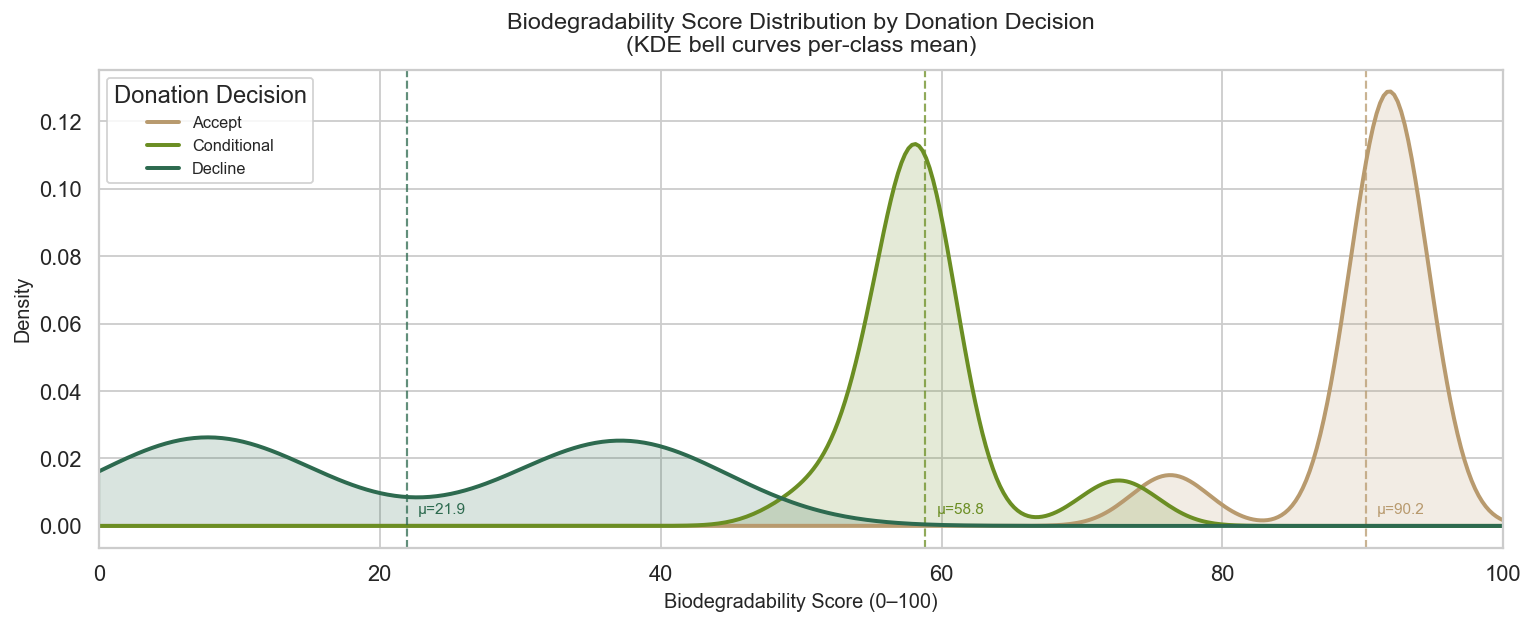

✓ 4-E-1 KDE chart saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/4E1_biodeg_score_kde.png


In [96]:
# ── 4-E-1  Donation decision distribution ────────────────────────────────
decision_df = spark.sql("""
    SELECT donation_decision,
           COUNT(*)                        AS item_count,
           ROUND(AVG(biodeg_score),  2)    AS avg_biodeg_score,
           ROUND(AVG(fs_bio_share),  1)    AS avg_bio_share_pct,
           ROUND(AVG(demand_index),  3)    AS avg_demand_index,
           ROUND(AVG(weight_kg),     3)    AS avg_weight_kg,
           ROUND(SUM(weight_kg),     2)    AS total_weight_kg
    FROM donations_transformed
    GROUP BY donation_decision
    ORDER BY avg_biodeg_score DESC
""")
decision_df.show()

# ── Bell-curve (KDE) — biodeg_score distribution per decision class ───────
_df = df_donors[["donation_decision", "fs_biodeg_score"]].copy()
_df["fs_biodeg_score"] = pd.to_numeric(_df["fs_biodeg_score"], errors="coerce")

DECISION_ORDER  = ["accept", "conditional", "decline"]
DECISION_COLORS = {
    "accept":      EARTH[3],
    "conditional": EARTH[6],
    "decline":     EARTH[8],
}

fig, ax = plt.subplots(figsize=(12, 5))

for decision_lbl in DECISION_ORDER:
    subset = _df.loc[_df["donation_decision"] == decision_lbl, "fs_biodeg_score"].dropna()
    if len(subset) < 2:
        continue
    color = DECISION_COLORS[decision_lbl]

    from scipy.stats import gaussian_kde
    kde    = gaussian_kde(subset, bw_method="scott")
    x_vals = np.linspace(0, 100, 400)
    y_vals = kde(x_vals)

    ax.plot(x_vals, y_vals, color=color, linewidth=2.2, label=decision_lbl.capitalize())
    ax.fill_between(x_vals, y_vals, alpha=0.18, color=color)

    mu = subset.mean()
    ax.axvline(mu, color=color, linewidth=1.2, linestyle="--", alpha=0.75)
    ax.text(mu + 0.8, ax.get_ylim()[1] * 0.02 if ax.get_ylim()[1] > 0 else 0.001,
            f"μ={mu:.1f}", color=color, fontsize=8.5, va="bottom")

ax.set_xlabel("Biodegradability Score (0–100)", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.set_title(
    "Biodegradability Score Distribution by Donation Decision\n"
    "(KDE bell curves per-class mean)",
    fontsize=13, pad=10,
)
ax.legend(title="Donation Decision", fontsize=9, framealpha=0.85)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(viz_path("4E1_biodeg_score_kde"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 4-E-1 KDE chart saved → {viz_path('4E1_biodeg_score_kde')}")


+-----------+----------+-------------+----------+----------------+-------------+---------------+--------+
|   ncr_city|item_count|request_count|avg_biodeg|avg_demand_index|avg_weight_kg|total_weight_kg|accepted|
+-----------+----------+-------------+----------+----------------+-------------+---------------+--------+
|Mandaluyong|        12|            3|     59.79|           0.681|        0.465|           5.58|       4|
|  Las Piñas|         9|            2|     49.05|           0.671|        0.394|           3.55|       2|
|   San Juan|         8|            2|     42.27|           0.596|        0.386|           3.09|       2|
|   Caloocan|         8|            2|     42.68|           0.781|        0.328|           2.62|       1|
|Quezon City|         7|            3|     32.53|           0.893|        0.438|           3.07|       1|
|    Pateros|         6|            3|     80.51|           0.612|        0.357|           2.14|       4|
|     Makati|         5|            1|     50.

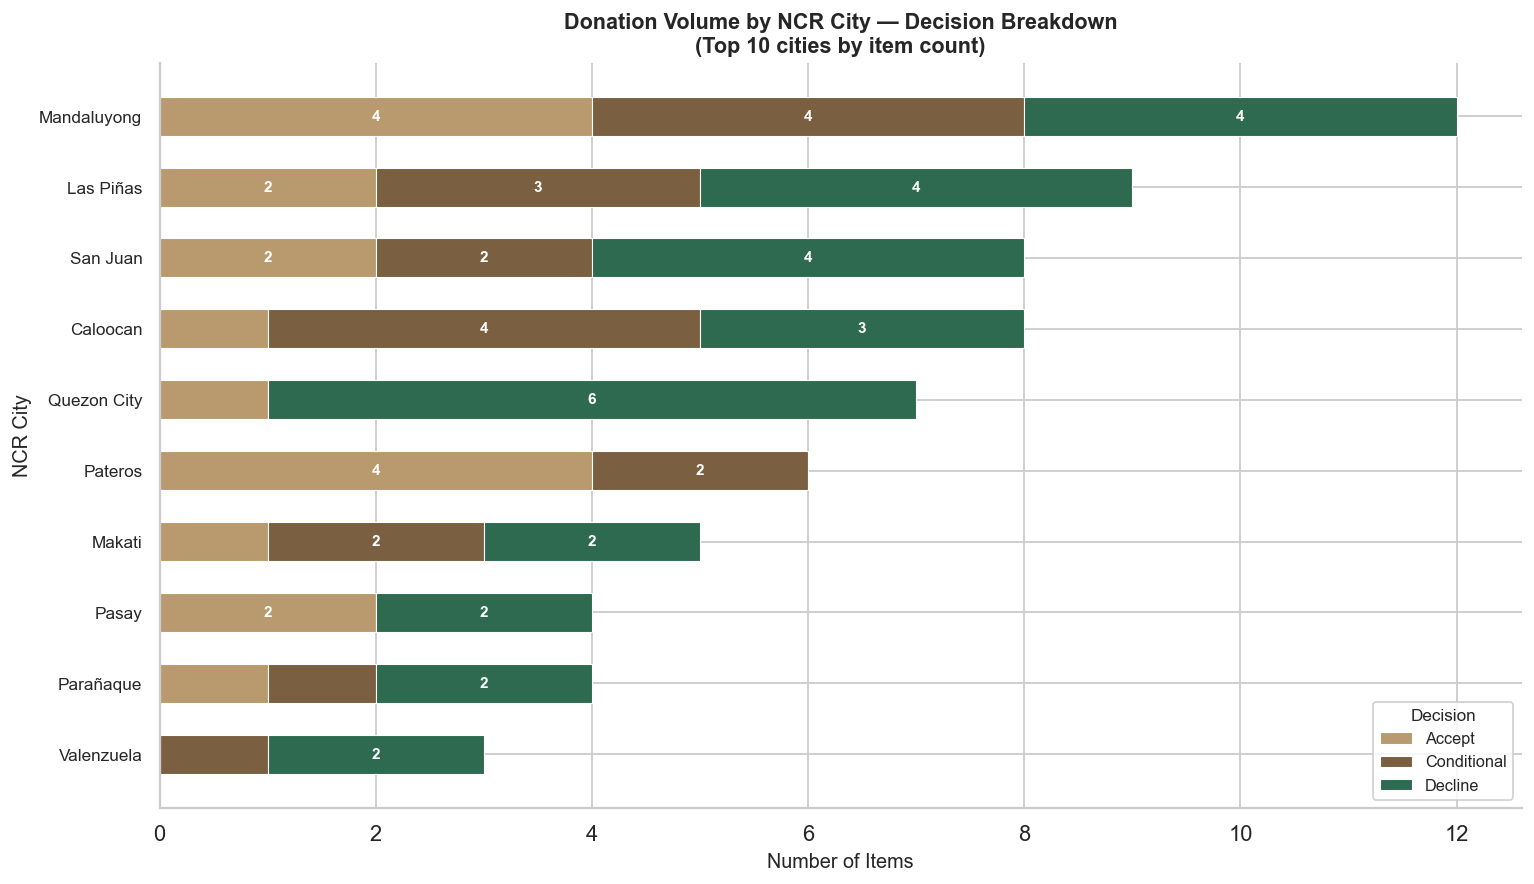

✓ 4-E-2 chart saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/4E2_city_donation_volume.png


In [97]:
# ── 4-E-2  Top 10 NCR cities by donation volume ───────────────────────────
spark.sql("""
    SELECT ncr_city,
           COUNT(*)                                                    AS item_count,
           COUNT(DISTINCT donation_id)                                 AS request_count,
           ROUND(AVG(biodeg_score),  2)                                AS avg_biodeg,
           ROUND(AVG(demand_index),  3)                                AS avg_demand_index,
           ROUND(AVG(weight_kg),     3)                                AS avg_weight_kg,
           ROUND(SUM(weight_kg),     2)                                AS total_weight_kg,
           SUM(CASE WHEN donation_decision = 'accept' THEN 1 ELSE 0 END) AS accepted
    FROM donations_transformed
    GROUP BY ncr_city
    ORDER BY item_count DESC
    LIMIT 10
""").show()

# ── Horizontal stacked barchart ───────────────────────────────────────────
_city_dec = (
    df_donors
    .groupby(["ncr_city", "donation_decision"])
    .size()
    .reset_index(name="count")
)

# Top-10 cities ordered by total item count (ascending so largest is at top)
_city_order = (
    _city_dec.groupby("ncr_city")["count"]
    .sum()
    .sort_values(ascending=True)
    .tail(10)
    .index.tolist()
)
_city_dec = _city_dec[_city_dec["ncr_city"].isin(_city_order)]
_pivot = (
    _city_dec
    .pivot(index="ncr_city", columns="donation_decision", values="count")
    .fillna(0)
    .astype(int)
    .reindex(_city_order)
)
for _col in ["accept", "conditional", "decline"]:
    if _col not in _pivot.columns:
        _pivot[_col] = 0
_pivot = _pivot[["accept", "conditional", "decline"]]

_bar_colors = [EARTH[3], EARTH[1], EARTH[8]]   # gold, tan, forest-green
_bar_labels = ["Accept", "Conditional", "Decline"]
_y          = range(len(_city_order))
_bar_height = 0.55

fig, ax = plt.subplots(figsize=(12, 7))
_left = [0] * len(_city_order)
for _dec_col, _label, _color in zip(
        ["accept", "conditional", "decline"], _bar_labels, _bar_colors):
    _vals = _pivot[_dec_col].values
    ax.barh(_y, _vals, _bar_height, left=_left,
            label=_label, color=_color, edgecolor="white", linewidth=0.6)
    for _j, (_v, _l) in enumerate(zip(_vals, _left)):
        if _v >= 2:
            ax.text(_l + _v / 2, _j, str(_v),
                    ha="center", va="center",
                    fontsize=8.5, color="white", fontweight="bold")
    _left = [_l + _v for _l, _v in zip(_left, _vals)]

ax.set_yticks(list(_y))
ax.set_yticklabels(_city_order, fontsize=9.5)
ax.set_ylabel("NCR City", fontsize=11)
ax.set_xlabel("Number of Items", fontsize=11)
ax.set_title("Donation Volume by NCR City — Decision Breakdown\n(Top 10 cities by item count)",
             fontsize=12, fontweight="bold")
ax.legend(title="Decision", fontsize=9, title_fontsize=9.5,
          loc="lower right", framealpha=0.85)
sns.despine(left=False, bottom=False)
plt.tight_layout()

plt.savefig(viz_path("4E2_city_donation_volume"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 4-E-2 chart saved → {viz_path('4E2_city_donation_volume')}")

+-------------+-----------+----------+-------------+---------------+
|clothing_type|biodeg_tier|item_count|avg_weight_kg|total_weight_kg|
+-------------+-----------+----------+-------------+---------------+
|        dress|       high|         8|        0.405|           3.24|
|        dress|        low|        27|        0.364|           9.82|
|        dress|     medium|        23|        0.398|           9.16|
|       jacket|        low|         2|        1.273|           2.55|
|        shirt|       high|         6|         0.23|           1.38|
|      t-shirt|       high|         3|        0.195|           0.58|
|      t-shirt|        low|         2|        0.228|           0.46|
+-------------+-----------+----------+-------------+---------------+



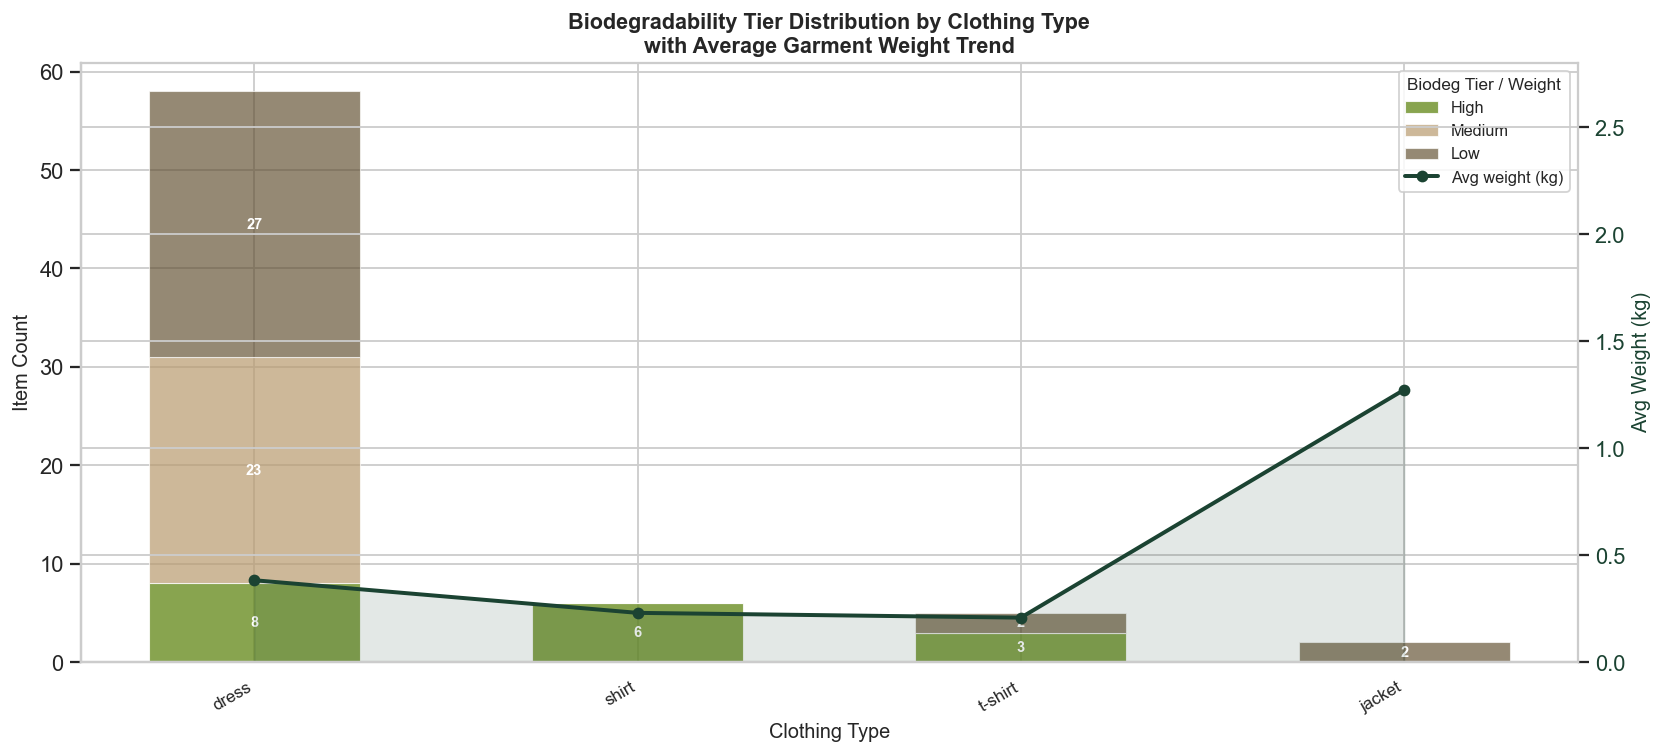

✓ 4-E-3 chart saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/4E3_biodeg_tier_by_clothing.png


In [98]:
# ── 4-E-3  Biodeg tier by clothing type + weight summary ─────────────────
spark.sql("""
    SELECT clothing_type,
           biodeg_tier,
           COUNT(*)                   AS item_count,
           ROUND(AVG(weight_kg), 3)   AS avg_weight_kg,
           ROUND(SUM(weight_kg), 2)   AS total_weight_kg
    FROM donations_transformed
    GROUP BY clothing_type, biodeg_tier
    ORDER BY clothing_type, biodeg_tier
""").show(30)

# ── Collect from Spark (biodeg_tier lives in df_transformed) ──
_df_e3 = (
    df_transformed
    .select("clothing_type", "biodeg_tier", "weight_kg", "donation_id")
    .toPandas()
)

# ── Pivot: clothing_type × biodeg_tier → item counts ─────────────────────
_tier_order   = ["high", "medium", "low"]
_tier_colors  = {"high": EARTH[6], "medium": EARTH[3], "low": EARTH[0]}
_tier_alpha   = {"high": 0.80, "medium": 0.70, "low": 0.65}

_pivot_cnt = (
    _df_e3.groupby(["clothing_type", "biodeg_tier"])
    .size()
    .reset_index(name="item_count")
    .pivot(index="clothing_type", columns="biodeg_tier", values="item_count")
    .fillna(0).astype(int)
)
for _t in _tier_order:
    if _t not in _pivot_cnt.columns:
        _pivot_cnt[_t] = 0
_pivot_cnt = _pivot_cnt[_tier_order]

# Sort by total item count descending
_ctype_order = _pivot_cnt.sum(axis=1).sort_values(ascending=False).index.tolist()
_pivot_cnt   = _pivot_cnt.reindex(_ctype_order)

# Average weight per clothing type
_avg_wt = _df_e3.groupby("clothing_type")["weight_kg"].mean().reindex(_ctype_order)

_x = list(range(len(_ctype_order)))

fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()

# ── Stacked bars ──────────────────────────────────────────────────────────
_bottom = [0.0] * len(_ctype_order)
for _tier in _tier_order:
    _vals = _pivot_cnt[_tier].values.astype(float)
    ax1.bar(_x, _vals, bottom=_bottom,
            color=_tier_colors[_tier], alpha=_tier_alpha[_tier],
            width=0.55, label=_tier.capitalize(),
            edgecolor="white", linewidth=0.6)
    for _j, (_v, _b) in enumerate(zip(_vals, _bottom)):
        if _v >= 2:
            ax1.text(_j, _b + _v / 2, str(int(_v)),
                     ha="center", va="center",
                     fontsize=8, color="white", fontweight="bold")
    _bottom = [_b + _v for _b, _v in zip(_bottom, _vals)]

# ── Avg-weight trend line + shaded area ───────────────────────────────────
_wt_vals = _avg_wt.values
ax2.plot(_x, _wt_vals, color=EARTH[9], linewidth=2.2,
         marker="o", markersize=5.5, label="Avg weight (kg)", zorder=5)
ax2.fill_between(_x, 0, _wt_vals, color=EARTH[9], alpha=0.12)

ax1.set_xticks(_x)
ax1.set_xticklabels(_ctype_order, rotation=30, ha="right", fontsize=9.5)
ax1.set_xlabel("Clothing Type", fontsize=11)
ax1.set_ylabel("Item Count", fontsize=11)
ax2.set_ylabel("Avg Weight (kg)", fontsize=11, color=EARTH[9])
ax2.tick_params(axis="y", labelcolor=EARTH[9])
ax2.set_ylim(0, max(_wt_vals) * 2.2)

ax1.set_title(
    "Biodegradability Tier Distribution by Clothing Type\n"
    "with Average Garment Weight Trend",
    fontsize=12, fontweight="bold"
)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           title="Biodeg Tier / Weight", fontsize=9,
           title_fontsize=9.5, loc="upper right", framealpha=0.85)

sns.despine(ax=ax1, left=False, bottom=False)
plt.tight_layout()

plt.savefig(viz_path("4E3_biodeg_tier_by_clothing"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 4-E-3 chart saved → {viz_path('4E3_biodeg_tier_by_clothing')}")

  Lookup fibers (8): ['alpaca', 'cotton', 'elastane', 'nylon', 'polyester', 'tencel', 'viscose', 'wool']
  Fibers in KPI (7): ['alpaca', 'cotton', 'elastane', 'nylon', 'polyester', 'tencel', 'viscose']


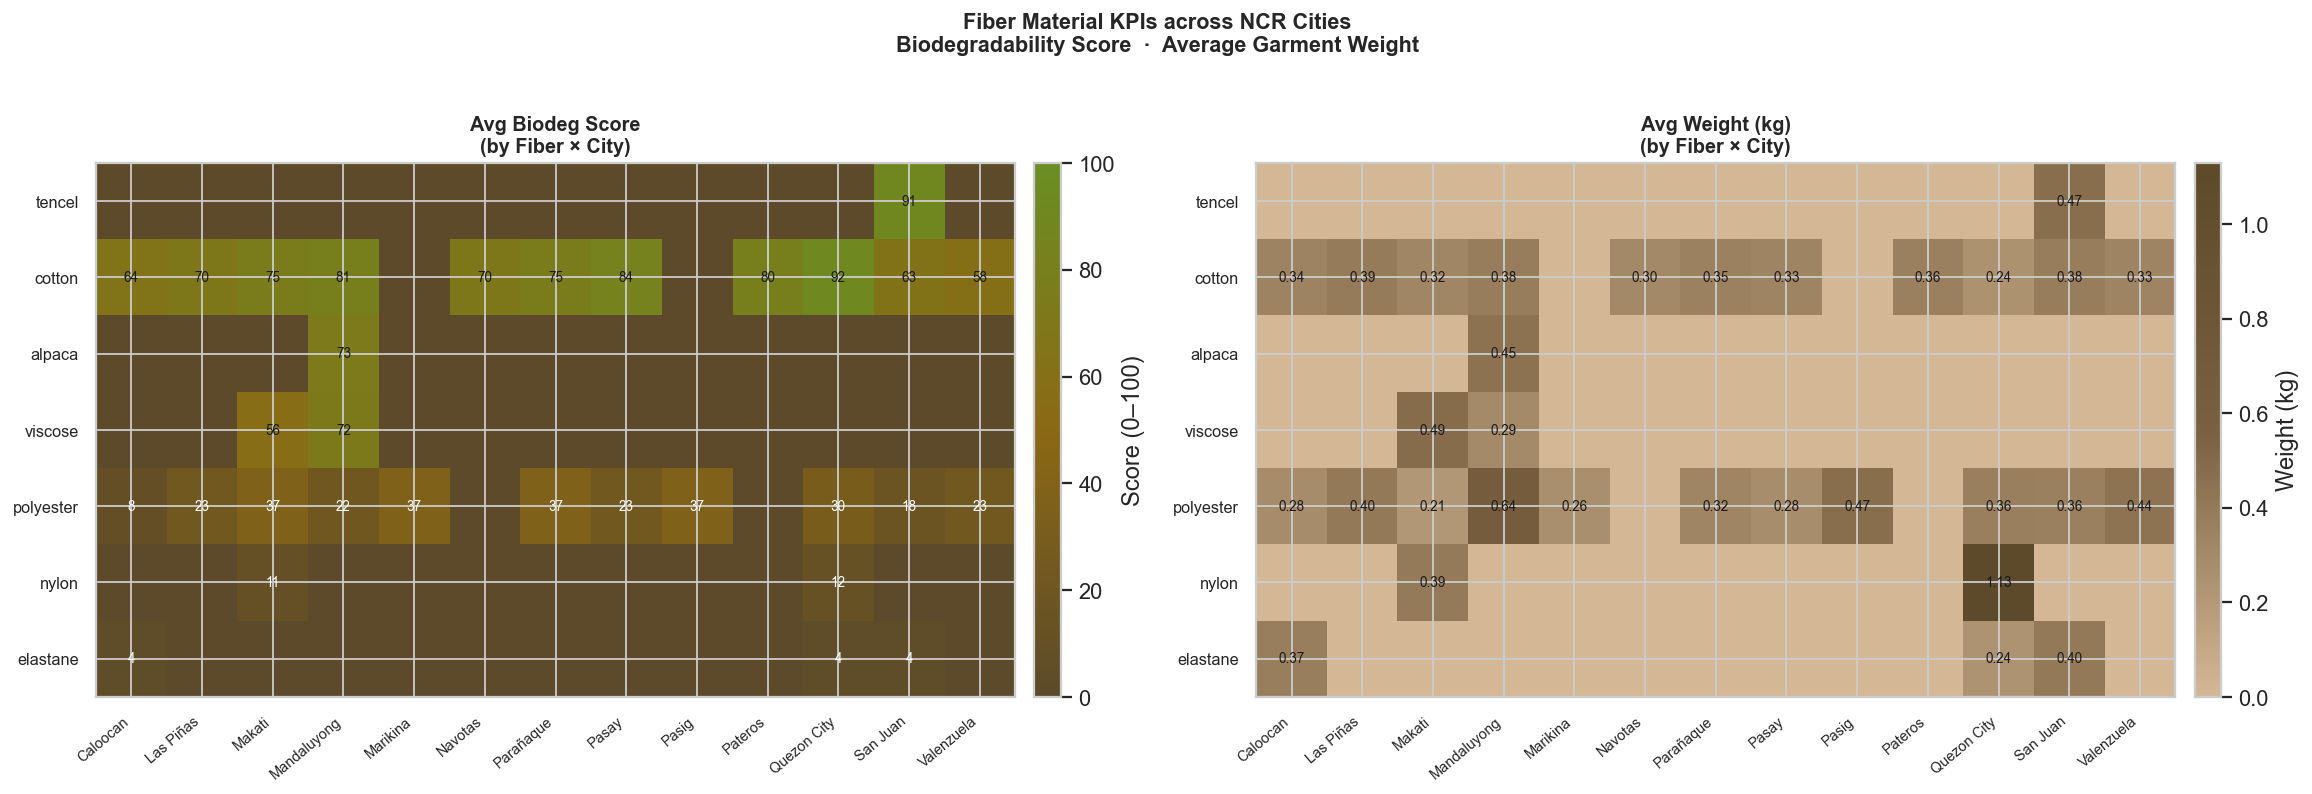

✓ 4-E-4 KPI heatmaps saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/4E4_fiber_kpi_city_heatmap.png


In [99]:
# ── 4-E-4  KPI — Fiber × City biodegradability & weight heatmaps ──────────
_kpi_df = (
    df_transformed
    .select("dominant_fiber_verified", "ncr_city", "biodeg_score", "weight_kg")
    .toPandas()
    .rename(columns={"dominant_fiber_verified": "dominant_fiber"})
)

# ── Derive fibers of interest from BRAND_FIBER_LOOKUP (brand_fiber_lookup.json)
_lookup_path = sorted(PROC_DIR.glob("*-brand_fiber_lookup.json"), reverse=True)
_lookup_path = _lookup_path[0] if _lookup_path else PROC_DIR / "brand_fiber_lookup.json"
with open(_lookup_path) as _f:
    _brand_lookup = json.load(_f)

_lookup_fibers      = {
    fiber
    for rec in _brand_lookup.values()
    for fiber in rec.get("fibers", {}).keys()
}
_fibers_in_data     = set(_kpi_df["dominant_fiber"].dropna().unique())
_FIBERS_OF_INTEREST = sorted(_lookup_fibers & _fibers_in_data)
print(f"  Lookup fibers ({len(_lookup_fibers)}): {sorted(_lookup_fibers)}")
print(f"  Fibers in KPI ({len(_FIBERS_OF_INTEREST)}): {_FIBERS_OF_INTEREST}")

_kpi_df = _kpi_df[_kpi_df["dominant_fiber"].isin(_FIBERS_OF_INTEREST)].copy()

# Pivot tables: fibers as rows, cities as columns
_pivot_bio = (
    _kpi_df.groupby(["dominant_fiber", "ncr_city"])["biodeg_score"]
    .mean().round(1)
    .unstack(fill_value=0)
)
_pivot_wt = (
    _kpi_df.groupby(["dominant_fiber", "ncr_city"])["weight_kg"]
    .mean().round(3)
    .unstack(fill_value=0)
)

# Sort fibers by mean biodeg score descending
_fiber_order = (
    _kpi_df.groupby("dominant_fiber")["biodeg_score"]
    .mean().sort_values(ascending=False).index.tolist()
)
_city_cols = sorted(_pivot_bio.columns.tolist())
_pivot_bio = _pivot_bio.reindex(index=_fiber_order, columns=_city_cols, fill_value=0)
_pivot_wt  = _pivot_wt.reindex(index=_fiber_order,  columns=_city_cols, fill_value=0)

# ── Dual heatmap layout ───────────────────────────────────────────────────
fig, (ax_bio, ax_wt) = plt.subplots(
    1, 2, figsize=(18, max(5, len(_fiber_order) * 0.65 + 1.5))
)

import matplotlib.colors as mcolors

_bio_cmap = mcolors.LinearSegmentedColormap.from_list(
    "earth_bio", [EARTH[0], EARTH[5], EARTH[6]], N=256
)
im1 = ax_bio.imshow(_pivot_bio.values, cmap=_bio_cmap, aspect="auto",
                    vmin=0, vmax=100)
ax_bio.set_xticks(range(len(_city_cols)))
ax_bio.set_xticklabels(_city_cols, rotation=40, ha="right", fontsize=8)
ax_bio.set_yticks(range(len(_fiber_order)))
ax_bio.set_yticklabels(_fiber_order, fontsize=9)
ax_bio.set_title("Avg Biodeg Score\n(by Fiber × City)", fontsize=11, fontweight="bold")
for _r, _fiber in enumerate(_fiber_order):
    for _c, _city in enumerate(_city_cols):
        _val = _pivot_bio.loc[_fiber, _city]
        if _val > 0:
            _txt_col = "white" if _val < 55 else "#1b1b1b"
            ax_bio.text(_c, _r, f"{_val:.0f}",
                        ha="center", va="center", fontsize=7.5, color=_txt_col)
fig.colorbar(im1, ax=ax_bio, fraction=0.03, pad=0.02, label="Score (0–100)")

_wt_cmap = mcolors.LinearSegmentedColormap.from_list(
    "earth_wt", [EARTH[4], EARTH[1], EARTH[0]], N=256
)
_wt_max = max(_pivot_wt.values.max(), 0.01)
im2 = ax_wt.imshow(_pivot_wt.values, cmap=_wt_cmap, aspect="auto",
                   vmin=0, vmax=_wt_max)
ax_wt.set_xticks(range(len(_city_cols)))
ax_wt.set_xticklabels(_city_cols, rotation=40, ha="right", fontsize=8)
ax_wt.set_yticks(range(len(_fiber_order)))
ax_wt.set_yticklabels(_fiber_order, fontsize=9)
ax_wt.set_title("Avg Weight (kg)\n(by Fiber × City)", fontsize=11, fontweight="bold")
for _r, _fiber in enumerate(_fiber_order):
    for _c, _city in enumerate(_city_cols):
        _val = _pivot_wt.loc[_fiber, _city]
        if _val > 0:
            ax_wt.text(_c, _r, f"{_val:.2f}",
                       ha="center", va="center", fontsize=7.5, color="#1b1b1b")
fig.colorbar(im2, ax=ax_wt, fraction=0.03, pad=0.02, label="Weight (kg)")

plt.suptitle(
    "Fiber Material KPIs across NCR Cities\n"
    "Biodegradability Score  ·  Average Garment Weight",
    fontsize=12, fontweight="bold", y=1.01
)
plt.tight_layout()
plt.savefig(viz_path("4E4_fiber_kpi_city_heatmap"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 4-E-4 KPI heatmaps saved → {viz_path('4E4_fiber_kpi_city_heatmap')}")

In [100]:
# ── 4-F  Persist transformed donor requests (timestamped + history) ──────
from datetime import datetime

_RUN_TS = datetime.now().strftime("%Y%m%d-%H%M%S")

PARQUET_PATH  = str(PROC_DIR / f"{_RUN_TS}-donor_requests.parquet")
CSV_PATH      = str(PROC_DIR / f"{_RUN_TS}-donor_requests.csv")

PARQUET_LATEST = str(PROC_DIR / "donor_requests_latest.parquet")
CSV_LATEST     = str(PROC_DIR / "donor_requests_latest.csv")

df_transformed.write.mode("overwrite").parquet(PARQUET_PATH)

_tmp_dir = str(PROC_DIR / "_dr_csv_tmp")
df_transformed.coalesce(1).write.mode("overwrite").option("header", True).csv(_tmp_dir)
part_files = glob.glob(str(PROC_DIR / "_dr_csv_tmp" / "part-*.csv"))
if part_files:
    shutil.move(part_files[0], CSV_PATH)
shutil.rmtree(_tmp_dir, ignore_errors=True)

df_transformed.write.mode("overwrite").parquet(PARQUET_LATEST)
_tmp_dir = str(PROC_DIR / "_dr_csv_tmp")
df_transformed.coalesce(1).write.mode("overwrite").option("header", True).csv(_tmp_dir)
part_files = glob.glob(str(PROC_DIR / "_dr_csv_tmp" / "part-*.csv"))
if part_files:
    shutil.move(part_files[0], CSV_LATEST)
shutil.rmtree(_tmp_dir, ignore_errors=True)

_hist_parquet = sorted(PROC_DIR.glob("*-donor_requests.parquet"))
_hist_csv     = sorted(PROC_DIR.glob("*-donor_requests.csv"))

print(f"✓ [{_RUN_TS}] donor_requests.parquet → {PARQUET_PATH}")
print(f"✓ [{_RUN_TS}] donor_requests.csv     → {CSV_PATH}")
print(f"✓ donor_requests_latest.parquet updated")
print(f"✓ donor_requests_latest.csv     updated")
print(f"\n── History ({len(_hist_parquet)} run(s)) ─────────────────────────────────────────")
for _p in _hist_parquet:
    print(f"  {_p.name}")

df_ml = df_transformed.toPandas()
print(f"\n✓ df_ml loaded — {len(df_ml):,} rows, {len(df_ml.columns)} cols")


✓ [20260225-160625] donor_requests.parquet → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/processed/20260225-160625-donor_requests.parquet
✓ [20260225-160625] donor_requests.csv     → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/processed/20260225-160625-donor_requests.csv
✓ donor_requests_latest.parquet updated
✓ donor_requests_latest.csv     updated

── History (2 run(s)) ─────────────────────────────────────────
  20260225-131851-donor_requests.parquet
  20260225-160625-donor_requests.parquet

✓ df_ml loaded — 71 rows, 23 cols


---
## 5 · Feature Engineering

Expands per-fiber percentages into individual numeric columns, encodes
categorical features, and defines `FEATURE_COLS` and the `donation_decision`
target for the CatBoost recommendation model.


In [101]:
# ── Derive fibers of interest from BRAND_FIBER_LOOKUP (brand_fiber_lookup.json)
_lookup_path = sorted(PROC_DIR.glob("*-brand_fiber_lookup.json"), reverse=True)
_lookup_path = _lookup_path[0] if _lookup_path else PROC_DIR / "brand_fiber_lookup.json"
with open(_lookup_path) as _f:
    _brand_lookup = json.load(_f)

_lookup_fibers      = {
    fiber
    for rec in _brand_lookup.values()
    for fiber in rec.get("fibers", {}).keys()
}
_fibers_in_data     = set(_kpi_df["dominant_fiber"].dropna().unique())
_FIBERS_OF_INTEREST = sorted(_lookup_fibers & _fibers_in_data)
print(f"  Lookup fibers ({len(_lookup_fibers)}): {sorted(_lookup_fibers)}")
print(f"  Fibers in KPI ({len(_FIBERS_OF_INTEREST)}): {_FIBERS_OF_INTEREST}")

# ── Cross-check: every lookup fiber must have an explicit BIODEG_SCORES entry ──
# Missing fibers fall back to score 30 ("unknown"), making biodeg_score and the
# donation_decision target label silently incorrect for those garments.
_unscored = sorted(_lookup_fibers - set(BIODEG_SCORES.keys()))
if _unscored:
    raise ValueError(
        f"\n\n  ✗ {len(_unscored)} lookup fiber(s) have NO entry in BIODEG_SCORES "
        f"and will produce incorrect biodeg_score / target labels:\n"
        f"    {_unscored}\n"
        f"  Add explicit scores to the BIODEG_SCORES cell before continuing."
    )
print(f"  ✓ All {len(_lookup_fibers)} lookup fibers have explicit BIODEG_SCORES entries "
      f"— no silent fallbacks.")

# ── Cross-check: lookup fiber scores vs. static dict (informational) ──────
print("\n  Lookup-fiber biodeg scores (from BIODEG_SCORES):")
for f in _FIBERS_OF_INTEREST:
    score = BIODEG_SCORES[f]
    tier  = "high" if score >= 75 else ("medium" if score >= 50 else "low")
    print(f"    {f:<18} score={score:>3}  tier={tier}")


  Lookup fibers (8): ['alpaca', 'cotton', 'elastane', 'nylon', 'polyester', 'tencel', 'viscose', 'wool']
  Fibers in KPI (7): ['alpaca', 'cotton', 'elastane', 'nylon', 'polyester', 'tencel', 'viscose']
  ✓ All 8 lookup fibers have explicit BIODEG_SCORES entries — no silent fallbacks.

  Lookup-fiber biodeg scores (from BIODEG_SCORES):
    alpaca             score= 73  tier=medium
    cotton             score= 92  tier=high
    elastane           score=  4  tier=low
    nylon              score= 12  tier=low
    polyester          score=  8  tier=low
    tencel             score= 91  tier=high
    viscose            score= 72  tier=medium


In [102]:
# ── 5-A  Fiber vocabulary + expand_fibers() ───────────────────────────────
# FIBER_VOCAB is scoped to fibers present in BRAND_FIBER_LOOKUP *and* in the
# actual dataset (_FIBERS_OF_INTEREST), so pct_* columns are granular
FIBER_VOCAB = list(_FIBERS_OF_INTEREST)           # e.g. ["cotton", "polyester", …]
PCT_COLS    = [f"pct_{f}" for f in FIBER_VOCAB]

# Full vocab (all fibers in BIODEG_SCORES) kept for fallback scoring only.
_FULL_FIBER_VOCAB = [k for k in BIODEG_SCORES if k != "unknown"]


def expand_fibers(df: pd.DataFrame) -> pd.DataFrame:
    """Expand fiber_json into pct_<fiber> columns for every fiber in FIBER_VOCAB."""
    fiber_data = {col: [] for col in PCT_COLS}
    for _, row in df.iterrows():
        try:    fibers = json.loads(row.get("fiber_json") or "{}")
        except: fibers = {}
        for col in PCT_COLS:
            fname = col.replace("pct_", "")
            fiber_data[col].append(float(fibers.get(fname, 0.0)))
    return pd.concat([df.reset_index(drop=True), pd.DataFrame(fiber_data)], axis=1)


print(f"✓ FIBER_VOCAB ({len(FIBER_VOCAB)} lookup fibers): {FIBER_VOCAB}")
print(f"  (full BIODEG_SCORES vocab has {len(_FULL_FIBER_VOCAB)} fibers — not used for PCT_COLS)")
print("✓ expand_fibers() ready")


✓ FIBER_VOCAB (7 lookup fibers): ['alpaca', 'cotton', 'elastane', 'nylon', 'polyester', 'tencel', 'viscose']
  (full BIODEG_SCORES vocab has 20 fibers — not used for PCT_COLS)
✓ expand_fibers() ready


In [103]:
# ── 5-A-2  Artisan business registry ─────────────────────────────────────
# ⚠  SYNTHETIC DATA DISCLAIMER ────────────────────────────────────────────
# All artisan business names, coordinates, fiber preferences, biodeg thresholds,
# and collection radii below are SYNTHETIC and have been fabricated for
# development and model-testing purposes only. They do NOT represent real
# businesses, individuals, or organisations. In production the WeaveForward
# Django API will populate this registry from the artisan_profiles database
# table (endpoint: /api/artisans/). Replace ARTISAN_REGISTRY with a live
# API call or database query before deploying the model against real data.
# ─────────────────────────────────────────────────────────────────────────
#
# Schema per artisan:
#   target_fibers     — list of accepted fiber types (priority order)
#   min_biodeg_score  — minimum acceptable biodegradability score (0–100)
#   max_distance_km   — donation collection radius from premises
# Lat/lon reuses real OSM geocodes from city_coords (4-A).

import math

ARTISAN_REGISTRY = [
    # ── Philippine NCR artisan businesses (SYNTHETIC) ─────────────────────
    {"artisan_id": "art-001", "artisan_name": "Habi Weaves Ermita",
     "target_fibers": ["cotton", "tencel"],          "min_biodeg_score": 60, "max_distance_km": 12.0,
     "latitude": city_coords["Manila"]["latitude"],
     "longitude": city_coords["Manila"]["longitude"]},

    {"artisan_id": "art-002", "artisan_name": "Diliman Fiber Collective",
     "target_fibers": ["tencel", "viscose"],         "min_biodeg_score": 70, "max_distance_km": 18.0,
     "latitude": city_coords["Quezon City"]["latitude"],
     "longitude": city_coords["Quezon City"]["longitude"]},

    {"artisan_id": "art-003", "artisan_name": "Makati Upcycle Studio",
     "target_fibers": ["cotton", "viscose", "tencel"], "min_biodeg_score": 55, "max_distance_km": 10.0,
     "latitude": city_coords["Makati"]["latitude"],
     "longitude": city_coords["Makati"]["longitude"]},

    {"artisan_id": "art-004", "artisan_name": "Pasig Natural Threads",
     "target_fibers": ["viscose", "cotton"],         "min_biodeg_score": 50, "max_distance_km": 15.0,
     "latitude": city_coords["Pasig"]["latitude"],
     "longitude": city_coords["Pasig"]["longitude"]},

    {"artisan_id": "art-005", "artisan_name": "Marikina Heritage Weavers",
     "target_fibers": ["alpaca", "cotton"],          "min_biodeg_score": 65, "max_distance_km": 20.0,
     "latitude": city_coords["Marikina"]["latitude"],
     "longitude": city_coords["Marikina"]["longitude"]},

    {"artisan_id": "art-006", "artisan_name": "Taguig EcoFabric Lab",
     "target_fibers": ["nylon", "polyester"],        "min_biodeg_score": 30, "max_distance_km": 14.0,
     "latitude": city_coords["Taguig"]["latitude"],
     "longitude": city_coords["Taguig"]["longitude"]},
]

df_artisans = pd.DataFrame(ARTISAN_REGISTRY)
# Convenience: comma-joined string of accepted fibers (used as categorical feature)
df_artisans["target_fibers_str"] = df_artisans["target_fibers"].apply(lambda x: ",".join(x))


def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Haversine great-circle distance in kilometres."""
    R = 6371.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlam = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlam / 2) ** 2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))


print("⚠  NOTE: All artisan data below is SYNTHETIC / for testing only.")
print(f"✓ {len(df_artisans)} artisan business profiles registered\n")
print(f"  {'Artisan':<34}  {'Accepted fibers':<28}  {'Min biodeg':>10}  {'Max dist (km)':>13}")
print(f"  {'-'*92}")
for _, r in df_artisans.iterrows():
    print(f"  {r['artisan_name']:<34}  {r['target_fibers_str']:<28}  "
          f"{r['min_biodeg_score']:>10}  {r['max_distance_km']:>13.1f}")


⚠  NOTE: All artisan data below is SYNTHETIC / for testing only.
✓ 6 artisan business profiles registered

  Artisan                             Accepted fibers               Min biodeg  Max dist (km)
  --------------------------------------------------------------------------------------------
  Habi Weaves Ermita                  cotton,tencel                         60           12.0
  Diliman Fiber Collective            tencel,viscose                        70           18.0
  Makati Upcycle Studio               cotton,viscose,tencel                 55           10.0
  Pasig Natural Threads               viscose,cotton                        50           15.0
  Marikina Heritage Weavers           alpaca,cotton                         65           20.0
  Taguig EcoFabric Lab                nylon,polyester                       30           14.0


In [127]:
# ── 5-B-1  Constants + base feature expansion ────────────────────────────
# Expand fiber_json → pct_<fiber> columns, clean numerics and categoricals,
# and derive helper columns used by every subsequent step.
#
# NOTE: pct_* columns are stored on a 0–100 scale (e.g. 85 = 85%).
# FIBER_MATCH_THRESHOLD is therefore expressed in the same scale.

FIBER_MATCH_THRESHOLD = 85.0   # biodegradability standard: ≥85% accepted-fiber share

df_base = expand_fibers(df_ml.copy())

# ── Cap pct_* values at 100 (guard against malformed fiber JSON) ──────────
for _c in PCT_COLS:
    if _c in df_base.columns:
        df_base[_c] = df_base[_c].clip(upper=100.0)

# ── Numeric cleanup ───────────────────────────────────────────────────────
for col, fill in [("biodeg_score", 30.0), ("fs_bio_share", 0.0),
                  ("demand_index", 0.5),  ("weight_kg",    0.5)]:
    df_base[col] = pd.to_numeric(df_base.get(col), errors="coerce").fillna(fill)
for col in ["latitude", "longitude"]:
    df_base[col] = pd.to_numeric(df_base.get(col), errors="coerce")
df_base["decision_label"] = (
    pd.to_numeric(df_base.get("decision_label"), errors="coerce").fillna(0).astype(int)
)

# ── Categorical cleanup ───────────────────────────────────────────────────
for col, default in [("brand", "unknown"), ("clothing_type", "unknown"),
                     ("most_dominant_fiber", "unknown"), ("source", "unknown"),
                     ("biodeg_tier", "low"), ("ncr_city", "Manila"),
                     ("barangay", "unknown")]:
    if col not in df_base.columns:
        df_base[col] = default
    df_base[col] = df_base[col].fillna(default).str.lower().str.strip()

# ── dominant_fiber_lookup — catalog-scoped dominant fiber ─────────────────
_foi_set = set(_FIBERS_OF_INTEREST)
df_base["dominant_fiber_lookup"] = (
    df_base["dominant_fiber_verified"].str.lower().str.strip()
    .where(df_base["dominant_fiber_verified"].str.lower().str.strip().isin(_foi_set),
           other="other")
    .fillna("other")
)

# ── pct_bio_lookup — bio-fiber share within lookup vocab only ─────────────
_bio_pct_cols = [f"pct_{f}" for f in FIBER_VOCAB if f in BIO_FIBERS]
df_base["pct_bio_lookup"] = df_base[_bio_pct_cols].sum(axis=1).clip(upper=100.0).round(4)

print(f"✓ df_base: {len(df_base):,} rows × {len(df_base.columns)} cols")
print(f"  pct_* columns   : {PCT_COLS}")
print(f"  bio pct cols    : {_bio_pct_cols}")
print(f"  FIBER_MATCH_THRESHOLD = {FIBER_MATCH_THRESHOLD}  (≥85% on 0–100 scale)")


✓ df_base: 71 rows × 32 cols
  pct_* columns   : ['pct_alpaca', 'pct_cotton', 'pct_elastane', 'pct_nylon', 'pct_polyester', 'pct_tencel', 'pct_viscose']
  bio pct cols    : ['pct_alpaca', 'pct_cotton', 'pct_tencel', 'pct_viscose']
  FIBER_MATCH_THRESHOLD = 85.0  (≥85% on 0–100 scale)


In [128]:
# ── 5-B-2  Donation × artisan cross-join (pair matrix) ───────────────────
# Every garment donation is paired with every artisan, producing a flat
# pair matrix that is the basis for the is_match binary label.

pair_rows = []
for _, artisan in df_artisans.iterrows():
    chunk = df_base.copy()

    # ── Artisan context columns ───────────────────────────────────────────
    chunk["artisan_id"]              = artisan["artisan_id"]
    chunk["artisan_name"]            = artisan["artisan_name"]
    chunk["artisan_lat"]             = artisan["latitude"]
    chunk["artisan_lon"]             = artisan["longitude"]
    chunk["artisan_min_biodeg"]      = artisan["min_biodeg_score"]
    chunk["artisan_max_dist_km"]     = artisan["max_distance_km"]
    chunk["artisan_target_fibers_str"] = artisan["target_fibers_str"]

    # ── pct_target_fiber — highest % across all of artisan's accepted fibers
    target_fibers   = artisan["target_fibers"]          # list
    pct_cols_here   = [f"pct_{f}" for f in target_fibers if f"pct_{f}" in chunk.columns]
    if pct_cols_here:
        chunk["pct_target_fiber"] = chunk[pct_cols_here].max(axis=1)
        chunk["matched_fiber"]    = (
            chunk[pct_cols_here].idxmax(axis=1).str.replace("pct_", "", regex=False)
        )
    else:
        chunk["pct_target_fiber"] = 0.0
        chunk["matched_fiber"]    = "none"

    pair_rows.append(chunk)

df_pairs = pd.concat(pair_rows, ignore_index=True)
print(f"✓ df_pairs: {len(df_pairs):,} rows  "
      f"({len(df_base):,} donations × {len(df_artisans)} artisans)")
print(f"  columns: {len(df_pairs.columns)}")


✓ df_pairs: 426 rows  (71 donations × 6 artisans)
  columns: 41


In [129]:
# ── 5-B-3  Derived match features + is_match label ───────────────────────
# Compute geographic distance, biodeg score for the target fiber, gate
# conditions, and the final binary is_match label.

# ── Geographic distance (haversine) ──────────────────────────────────────
df_pairs["distance_km"] = df_pairs.apply(
    lambda r: haversine_km(r["latitude"], r["longitude"],
                           r["artisan_lat"], r["artisan_lon"]),
    axis=1,
).round(3)

# ── Biodeg score for the matched fiber specifically ───────────────────────
df_pairs["biodeg_target_fiber"] = (
    df_pairs["matched_fiber"].map(BIODEG_SCORES).fillna(30.0)
)

# ── Gate conditions ───────────────────────────────────────────────────────
df_pairs["biodeg_meets_min"] = (
    df_pairs["biodeg_score"] >= df_pairs["artisan_min_biodeg"]
).astype(int)
df_pairs["within_radius"] = (
    df_pairs["distance_km"] <= df_pairs["artisan_max_dist_km"]
).astype(int)

# ── Binary label ─────────────────────────────────────────────────────────
df_pairs["is_match"] = (
    (df_pairs["pct_target_fiber"] >= FIBER_MATCH_THRESHOLD)
    & (df_pairs["biodeg_meets_min"] == 1)
    & (df_pairs["within_radius"]    == 1)
).astype(int)

df_feat = df_pairs   # alias used by downstream cells

# ── Summary ───────────────────────────────────────────────────────────────
n_match    = df_feat["is_match"].sum()
n_no_match = len(df_feat) - n_match
print(f"✓ df_feat: {len(df_feat):,} pairs")
print(f"  is_match=1 (match)    : {n_match:,}  ({n_match/len(df_feat)*100:.1f}%)")
print(f"  is_match=0 (no-match) : {n_no_match:,}  ({n_no_match/len(df_feat)*100:.1f}%)")
print()
print("Matches per artisan:")
print(
    df_feat.groupby("artisan_name")["is_match"]
    .agg(matches="sum", total="count")
    .assign(match_rate=lambda d: (d["matches"] / d["total"]).map("{:.1%}".format))
    .to_string()
)


✓ df_feat: 426 pairs
  is_match=1 (match)    : 54  (12.7%)
  is_match=0 (no-match) : 372  (87.3%)

Matches per artisan:
                           matches  total match_rate
artisan_name                                        
Diliman Fiber Collective         1     71       1.4%
Habi Weaves Ermita              13     71      18.3%
Makati Upcycle Studio           12     71      16.9%
Marikina Heritage Weavers       14     71      19.7%
Pasig Natural Threads           14     71      19.7%
Taguig EcoFabric Lab             0     71       0.0%


In [130]:
# ── 5-B-4  Sample results view ────────────────────────────────────────────
# ⚠ ALL DATA BELOW IS SYNTHETIC — artisan registry and donation records
#   were fabricated for pipeline development.  Do not treat as real.

_DISPLAY_COLS = ["artisan_name", "matched_fiber", "pct_target_fiber",
                 "biodeg_score", "distance_km", "is_match",
                 "brand", "clothing_type", "most_dominant_fiber"]

print("── Top 10 confirmed matches (is_match = 1) ─────────────────────────────")
_sample = (
    df_feat[df_feat["is_match"] == 1][_DISPLAY_COLS]
    .sort_values("pct_target_fiber", ascending=False)
    .head(10)
)
display(_sample.reset_index(drop=True))

print("\n── Top 5 closest-miss pairs (is_match = 0, highest pct_target_fiber) ───")
_miss = (
    df_feat[df_feat["is_match"] == 0][_DISPLAY_COLS]
    .sort_values("pct_target_fiber", ascending=False)
    .head(5)
)
display(_miss.reset_index(drop=True))


── Top 10 confirmed matches (is_match = 1) ─────────────────────────────


,artisan_name,matched_fiber,pct_target_fiber,biodeg_score,distance_km,is_match,brand,clothing_type,most_dominant_fiber
0,Habi Weaves Ermita,cotton,100.0,92.0,8.222,1,mango,t-shirt,cotton
1,Pasig Natural Threads,cotton,100.0,92.0,2.289,1,penshoppe,dress,cotton
2,Pasig Natural Threads,cotton,100.0,92.0,6.479,1,penshoppe,dress,cotton
3,Pasig Natural Threads,cotton,100.0,92.0,6.479,1,mango,shirt,cotton
4,Pasig Natural Threads,cotton,100.0,92.0,6.479,1,mango,dress,cotton
5,Pasig Natural Threads,cotton,100.0,92.0,7.595,1,mango,shirt,cotton
6,Pasig Natural Threads,cotton,100.0,92.0,14.460,1,mango,shirt,cotton
7,Pasig Natural Threads,cotton,100.0,92.0,7.330,1,penshoppe,dress,cotton
8,Pasig Natural Threads,viscose,100.0,72.0,6.646,1,penshoppe,dress,viscose
9,Pasig Natural Threads,cotton,100.0,92.0,4.211,1,penshoppe,dress,cotton



── Top 5 closest-miss pairs (is_match = 0, highest pct_target_fiber) ───


,artisan_name,matched_fiber,pct_target_fiber,biodeg_score,distance_km,is_match,brand,clothing_type,most_dominant_fiber
0,Habi Weaves Ermita,cotton,100.0,92.0,12.504,0,penshoppe,dress,cotton
1,Habi Weaves Ermita,cotton,100.0,92.0,15.016,0,mango,shirt,cotton
2,Makati Upcycle Studio,cotton,100.0,92.0,11.497,0,mango,shirt,cotton
3,Makati Upcycle Studio,cotton,100.0,92.0,14.551,0,mango,shirt,cotton
4,Makati Upcycle Studio,cotton,100.0,92.0,12.699,0,mango,shirt,cotton


In [131]:
# ── 5-C  Define feature columns + binary target ─────────────────────────
# Target: is_match (1 = donation satisfies artisan requirements, 0 = no match)
# Feature design:
#   PCT_COLS                 — granular per-fiber composition from scraped fiber_json
#   pct_target_fiber         — max pct_* across artisan's accepted fibers (key signal)
#   matched_fiber            — which accepted fiber achieved the max pct (categorical)
#   artisan_target_fibers_str — full list of artisan's accepted fibers (categorical)
#   distance_km              — haversine donor → artisan premises (key geo signal)
#   biodeg_target_fiber      — BIODEG_SCORES of matched_fiber
#   artisan_min_biodeg       — artisan's stated threshold (numeric boundary context)
#   artisan_max_dist_km      — artisan's collection radius (numeric boundary context)
# Excluded: biodeg_meets_min, within_radius — direct binary gates (leakage risk)

CAT_FEATURES = [
    # ── Donor garment identity ────────────────────────────────────────────
    "brand",
    "clothing_type",
    "source",
    # ── Fiber categoricals ────────────────────────────────────────────────
    "most_dominant_fiber",       # full-vocab dominant fiber (raw)
    "dominant_fiber_lookup",     # catalog-scoped dominant fiber
    "matched_fiber",             # which of the artisan's accepted fibers had the highest % in this donation
    "biodeg_tier",               # explicit biodeg discretisation
    # ── Donor geography ───────────────────────────────────────────────────
    # region excluded (constant "ncr", zero variance)
    "ncr_city",
    "barangay",
    # ── Artisan context ───────────────────────────────────────────────────
    "artisan_id",                # artisan identity (CatBoost can learn per-artisan bias)
    "artisan_target_fibers_str", # comma-joined list of all accepted fibers
]

FEATURE_COLS = (
    PCT_COLS                         # scraped per-fiber % (pct_cotton, pct_polyester, …)
    + [
        "pct_bio_lookup",            # bio-fiber share within lookup vocab
        "fs_bio_share",              # bio-fiber share across full fiber_json
        "biodeg_score",              # donation biodeg weighted avg (BIODEG_SCORES × pct)
        "biodeg_target_fiber",       # BIODEG_SCORES[matched_fiber]
        "artisan_min_biodeg",        # artisan's stated minimum biodeg requirement
        "demand_index",              # NCR city normalized demand proxy
        "weight_kg",
        "latitude", "longitude",     # donor coords
        "distance_km",               # haversine donor → artisan (key proximity signal)
        "pct_target_fiber",          # max % across accepted fibers (key fiber-match signal)
        "artisan_max_dist_km",       # artisan's collection radius (spatial context)
    ]
    + CAT_FEATURES
)

TARGET = "is_match"   # 1 = match, 0 = no match

X = df_feat[FEATURE_COLS].copy()
y = df_feat[TARGET].copy()

print("Feature summary (binary is_match classifier)")
print(f"  pct_* (lookup fibers)      : {len(PCT_COLS)}  → {FIBER_VOCAB}")
print(f"  match-signal numerics      : pct_target_fiber, distance_km,")
print(f"                               biodeg_target_fiber, artisan_min_biodeg, artisan_max_dist_km")
print(f"  standard numerics          : pct_bio_lookup, fs_bio_share, biodeg_score,")
print(f"                               demand_index, weight_kg, latitude, longitude")
print(f"  categoricals ({len(CAT_FEATURES)})          : {CAT_FEATURES}")
print(f"  [excluded] region          : constant='ncr', zero variance — dropped")
print(f"  [excluded] biodeg_meets_min, within_radius  — direct label gates (leakage risk)")
print(f"  total features             : {len(FEATURE_COLS)}")
print(f"\nTarget ({TARGET}) distribution:")
for v, cnt in y.value_counts().sort_index().items():
    lbl = "match" if v == 1 else "no_match"
    print(f"  {lbl:<10} ({v})  {cnt:>6,}  {cnt / len(y) * 100:.1f}%")

print(f"\n  Fiber-level match breakdown (matched_fiber column):")
for fiber, g in df_feat[df_feat["is_match"] == 1].groupby("matched_fiber"):
    print(f"    {fiber:<18}  {len(g):>5,} matched pairs")


Feature summary (binary is_match classifier)
  pct_* (lookup fibers)      : 7  → ['alpaca', 'cotton', 'elastane', 'nylon', 'polyester', 'tencel', 'viscose']
  match-signal numerics      : pct_target_fiber, distance_km,
                               biodeg_target_fiber, artisan_min_biodeg, artisan_max_dist_km
  standard numerics          : pct_bio_lookup, fs_bio_share, biodeg_score,
                               demand_index, weight_kg, latitude, longitude
  categoricals (11)          : ['brand', 'clothing_type', 'source', 'most_dominant_fiber', 'dominant_fiber_lookup', 'matched_fiber', 'biodeg_tier', 'ncr_city', 'barangay', 'artisan_id', 'artisan_target_fibers_str']
  [excluded] region          : constant='ncr', zero variance — dropped
  [excluded] biodeg_meets_min, within_radius  — direct label gates (leakage risk)
  total features             : 30

Target (is_match) distribution:
  no_match   (0)     372  87.3%
  match      (1)      54  12.7%

  Fiber-level match breakdown (matched

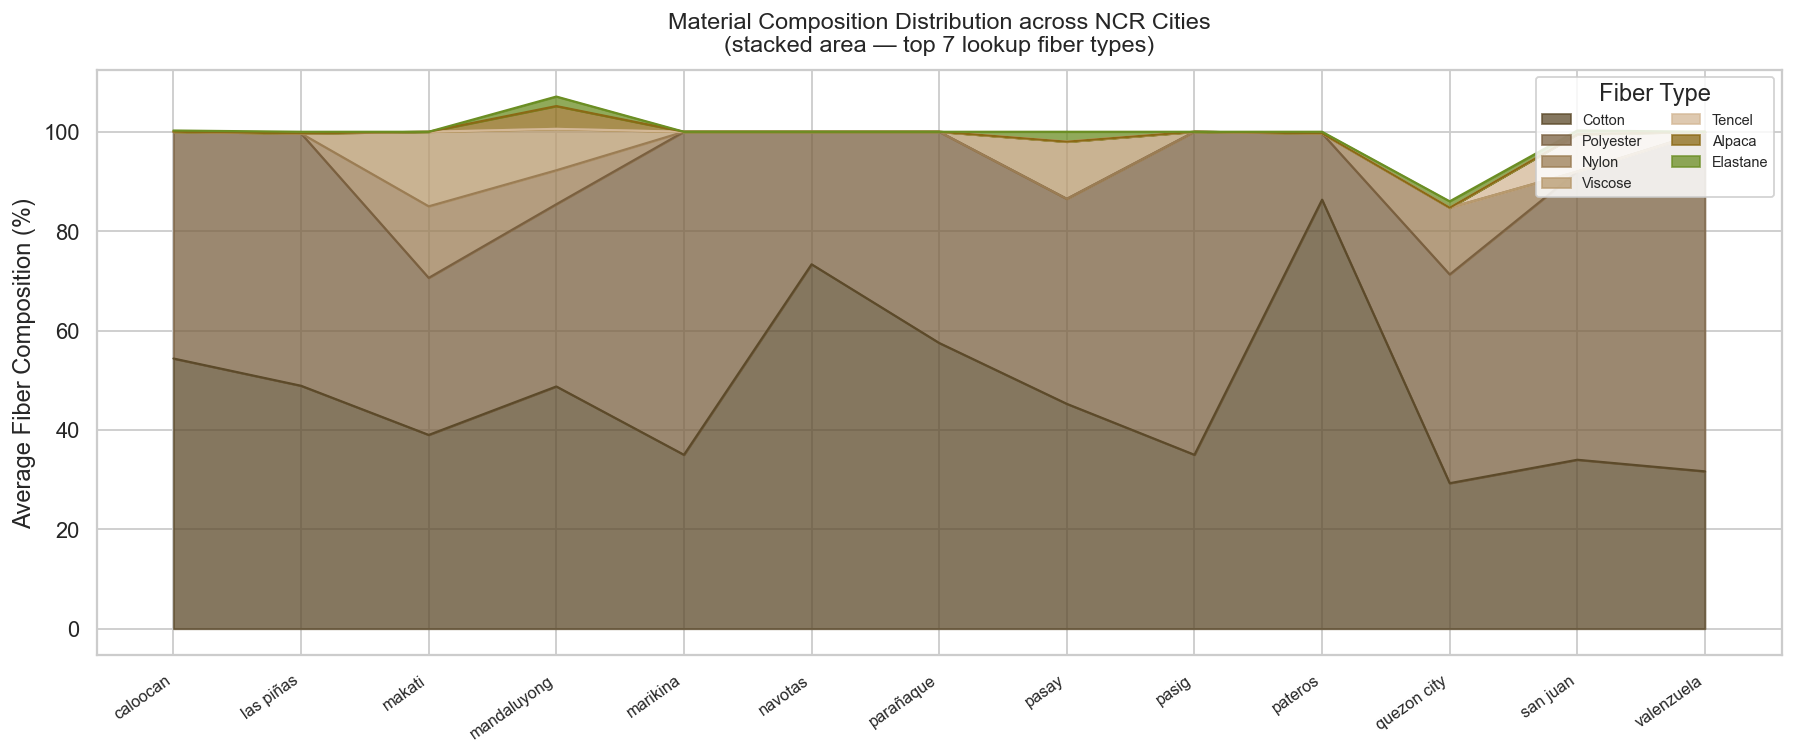

✓ 6-A saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/6A_city_fiber_area.png


In [107]:
# ── 6-A  Area/line graph — avg fiber composition per NCR city ─────────────
# Shows how material prevalence shifts across Metro Manila cities.
# TOP_FIBERS is capped at min(8, len(PCT_COLS)) so the chart always fits
# within the lookup-fiber vocabulary.

_top_n    = min(8, len(PCT_COLS))
TOP_FIBERS = (df_feat[PCT_COLS]
              .mean()
              .nlargest(_top_n)
              .index
              .tolist())

city_fiber = (df_feat
              .groupby("ncr_city")[TOP_FIBERS]
              .mean()
              .reset_index()
              .sort_values("ncr_city"))

fig, ax = plt.subplots(figsize=(14, 6))
x       = np.arange(len(city_fiber))
bottom  = np.zeros(len(city_fiber))

for i, col in enumerate(TOP_FIBERS):
    fiber_name = col.replace("pct_", "").capitalize()
    ax.fill_between(x, bottom, bottom + city_fiber[col].values,
                    alpha=0.75, color=EARTH[i % len(EARTH)],
                    label=fiber_name)
    ax.plot(x, bottom + city_fiber[col].values,
            color=EARTH[i % len(EARTH)], linewidth=1.2)
    bottom = bottom + city_fiber[col].values

ax.set_xticks(x)
ax.set_xticklabels(city_fiber["ncr_city"], rotation=35, ha="right", fontsize=9)
ax.set_ylabel("Average Fiber Composition (%)")
ax.set_title(f"Material Composition Distribution across NCR Cities\n"
             f"(stacked area — top {_top_n} lookup fiber types)", fontsize=13, pad=10)
ax.legend(loc="upper right", fontsize=8, ncol=2,
          framealpha=0.85, title="Fiber Type")
plt.tight_layout()
plt.savefig(viz_path("6A_city_fiber_area"), dpi=150)
plt.show()
print(f"✓ 6-A saved → {viz_path('6A_city_fiber_area')}")


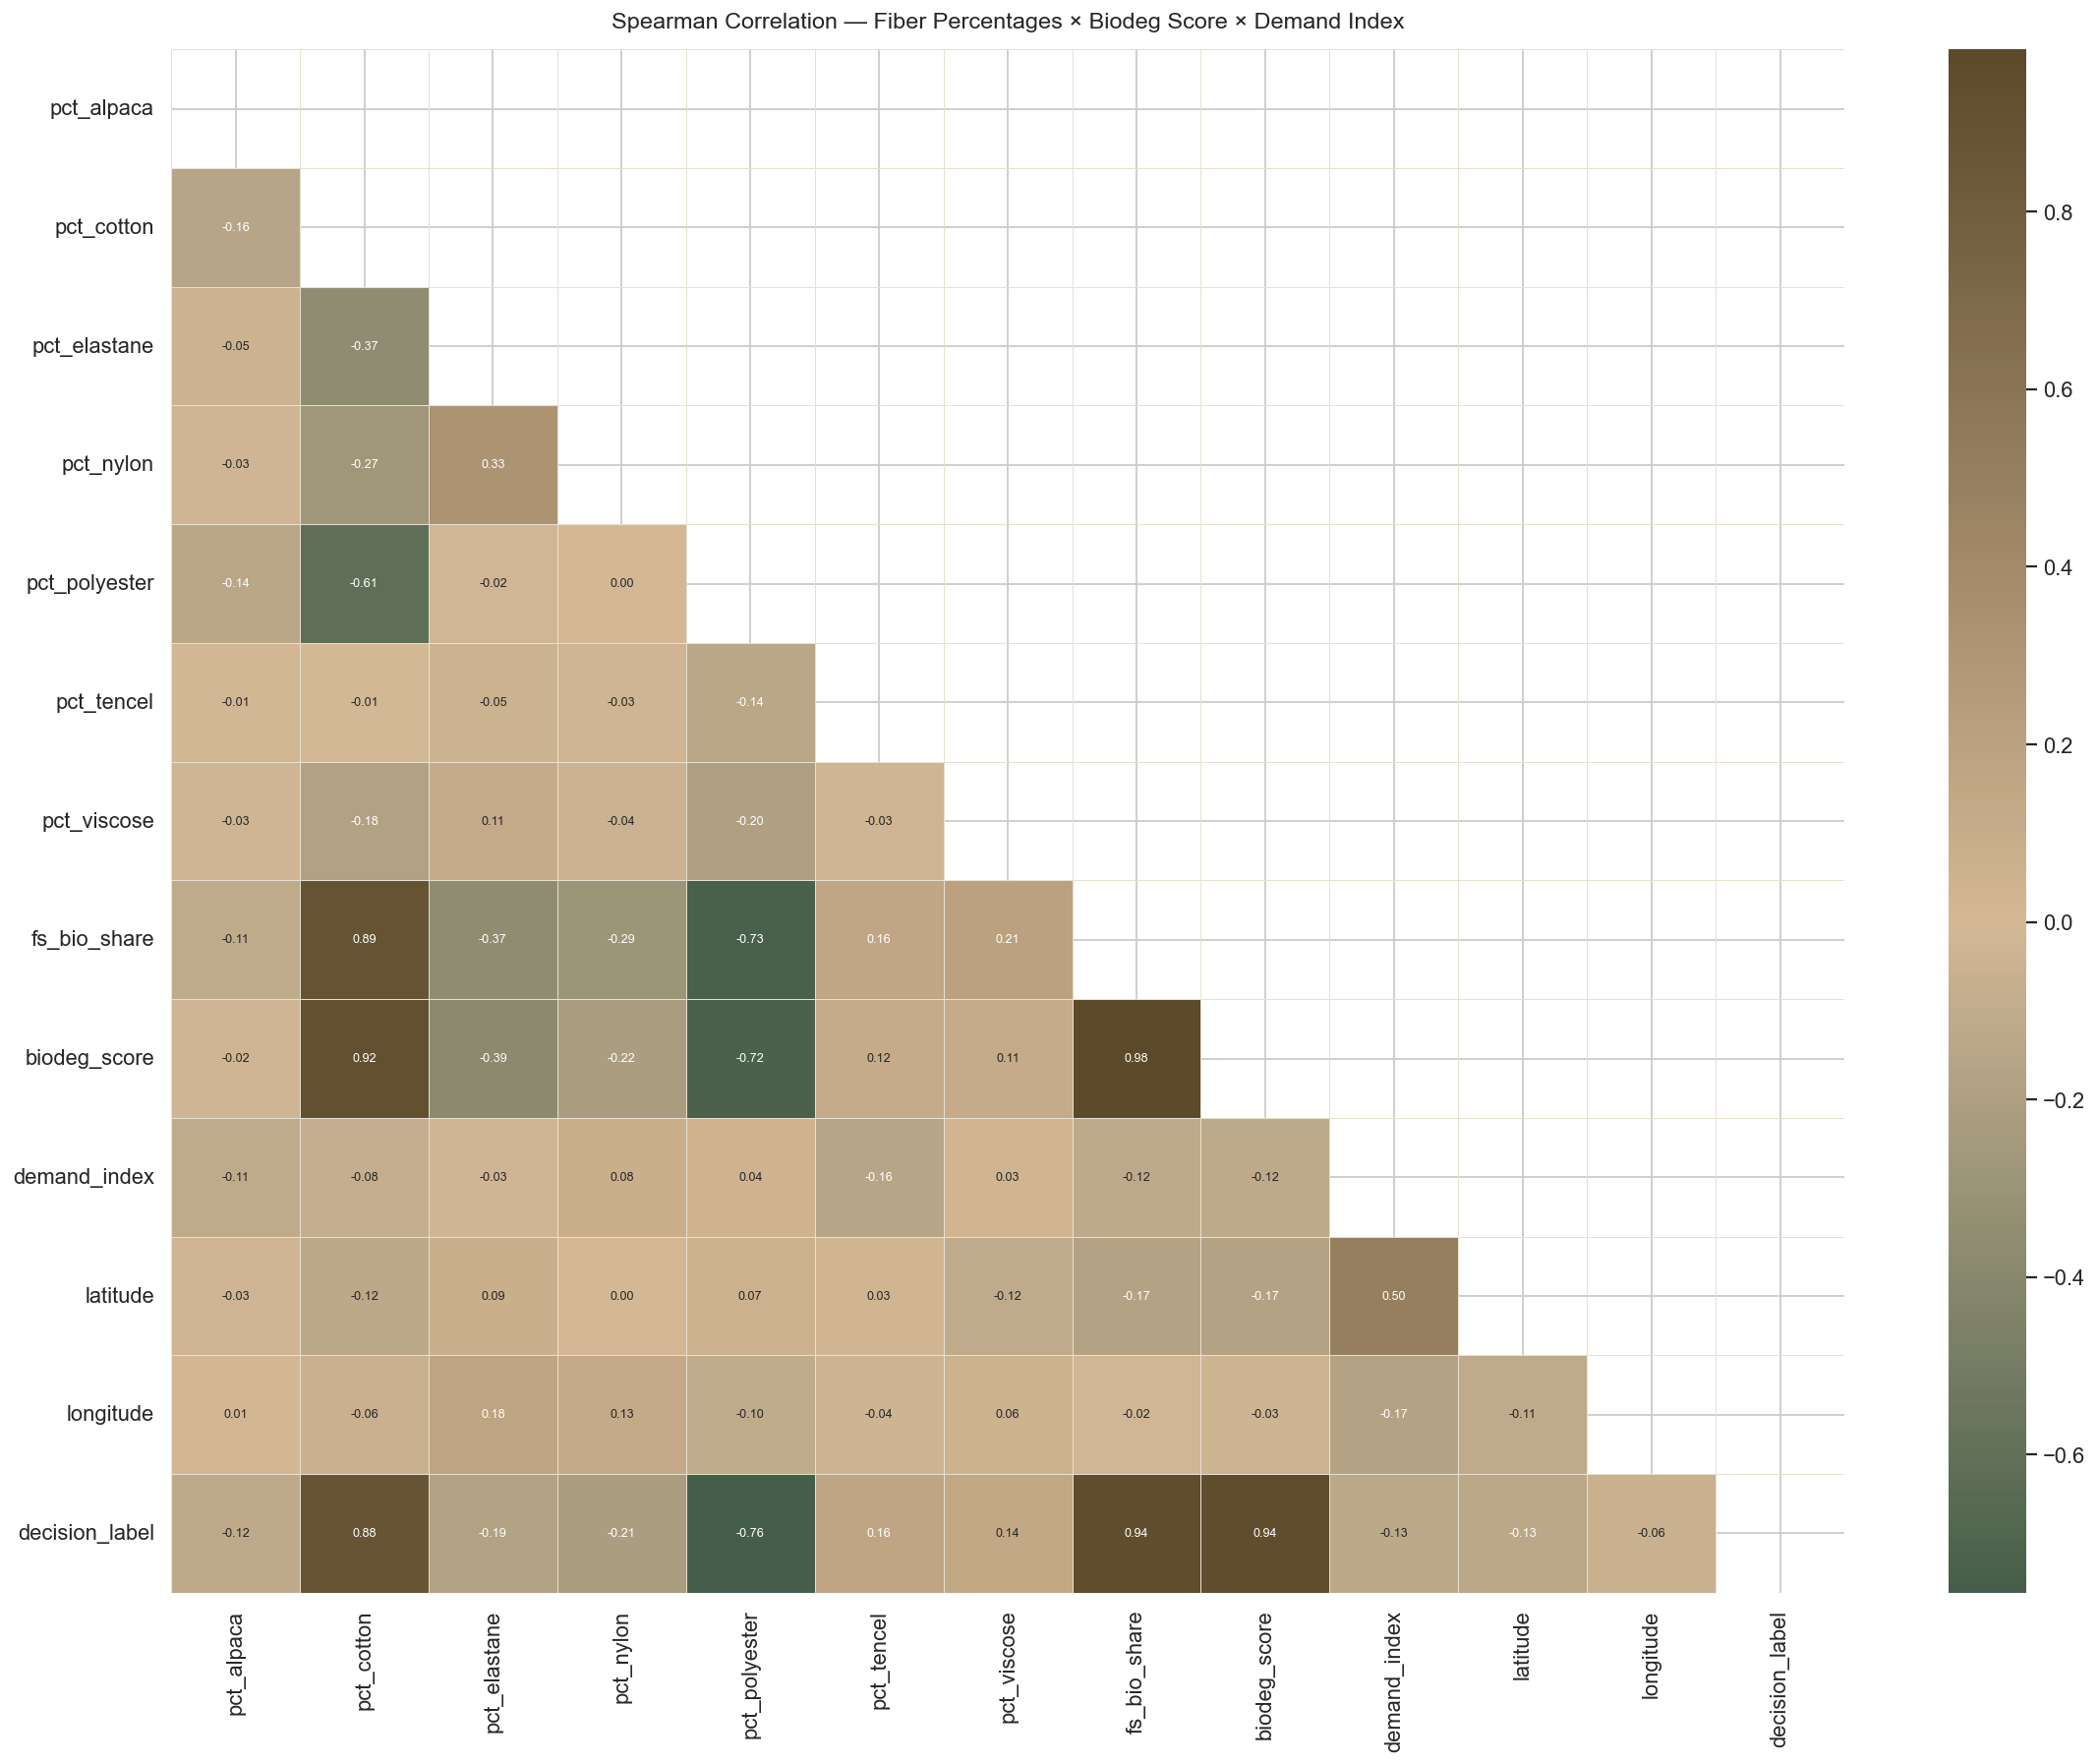

✓ 6-B saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/6B_correlation_heatmap.png


In [108]:
# ── 6-B  Correlation heatmap — quantitative features × biodeg score ────────
QUANT_COLS = (PCT_COLS
              + ["fs_bio_share", "biodeg_score", "demand_index",
                 "latitude", "longitude", "decision_label"])

corr_df = df_feat[QUANT_COLS].fillna(0).corr(method="spearman")
mask    = np.triu(np.ones_like(corr_df, dtype=bool))

earth_cmap = sns.blend_palette(["#1b4332", "#d4b896", "#5c4a2a"], as_cmap=True)

fig, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(corr_df, mask=mask, annot=True, fmt=".2f",
            cmap=earth_cmap, center=0,
            linewidths=0.3, linecolor="#e8e0d0",
            ax=ax, annot_kws={"size": 7})
ax.set_title(
    "Spearman Correlation — Fiber Percentages × Biodeg Score × Demand Index",
    fontsize=13, pad=12)
plt.tight_layout()
plt.savefig(viz_path("6B_correlation_heatmap"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-B saved → {viz_path('6B_correlation_heatmap')}")


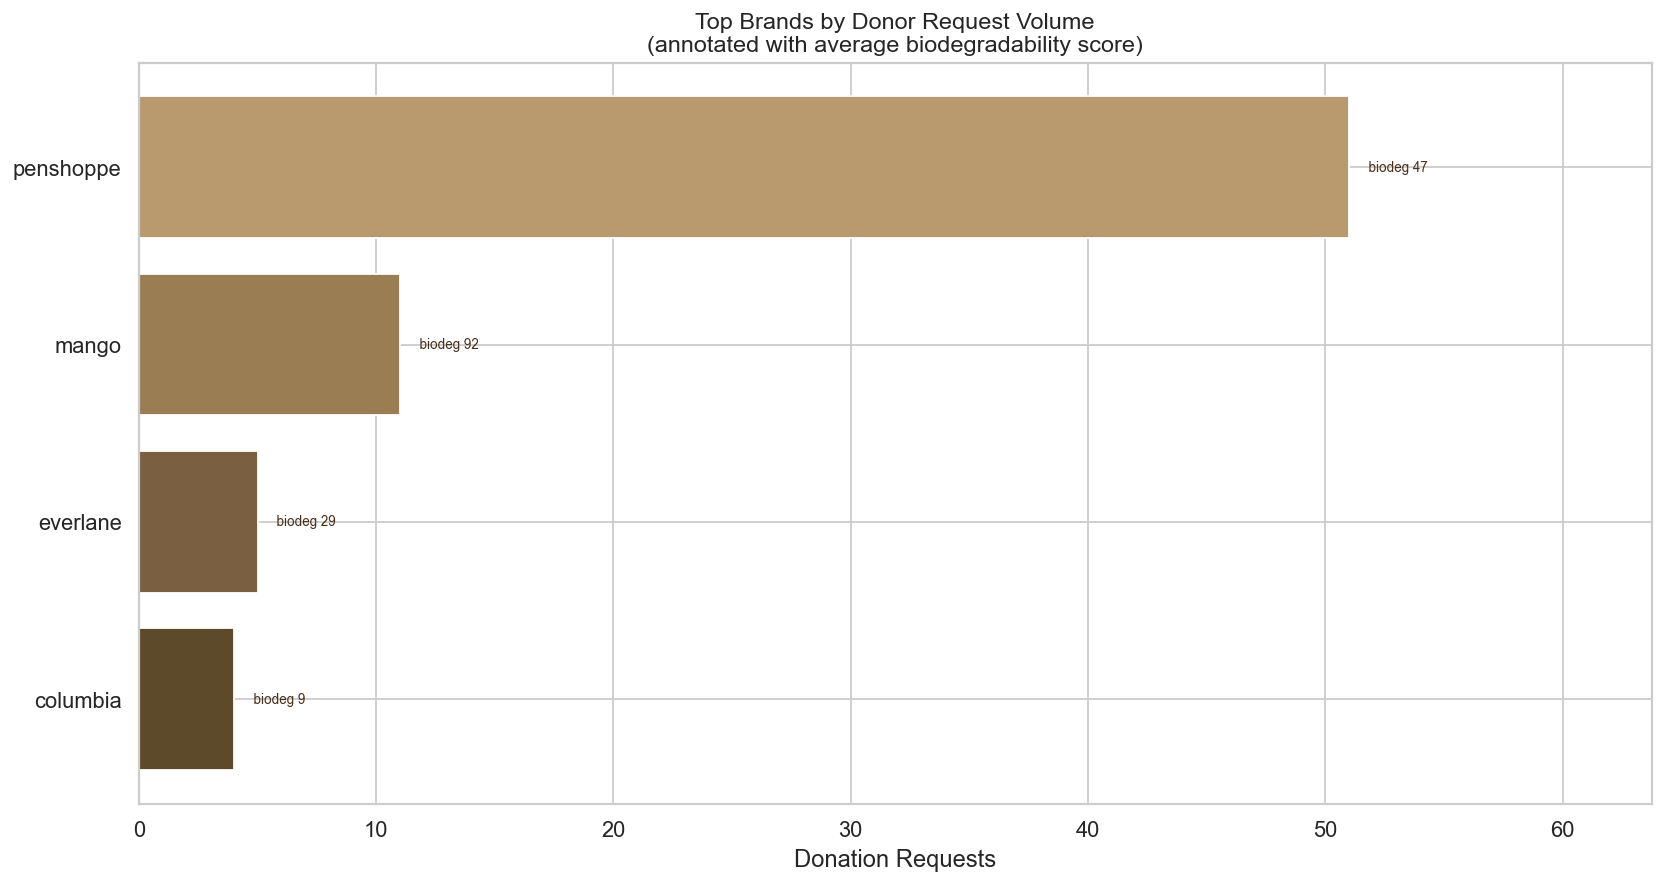

✓ 6-C saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/6C_brand_distribution.png


In [74]:
# ── 6-C  Brand distribution — top brands by donation request count ─────
brand_counts = (df_feat.groupby("brand")
                .agg(count=("donation_id", "count"),
                     avg_biodeg=("biodeg_score", "mean"),
                     avg_bio_share=("fs_bio_share", "mean"))
                .reset_index()
                .sort_values("count", ascending=False)
                .head(20))

fig, ax = plt.subplots(figsize=(13, 7))
bars = ax.barh(brand_counts["brand"][::-1],
               brand_counts["count"][::-1],
               color=sns.color_palette(EARTH, len(brand_counts)))
# annotate with avg biodeg score
for bar, (_, row) in zip(bars, brand_counts[::-1].iterrows()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"  biodeg {row['avg_biodeg']:.0f}", va="center",
            fontsize=7.5, color="#4a2f1a")

ax.set_xlabel("Donation Requests")
ax.set_title("Top Brands by Donor Request Volume\n"
             "(annotated with average biodegradability score)", fontsize=13)
ax.set_xlim(0, brand_counts["count"].max() * 1.25)
plt.tight_layout()
plt.savefig(viz_path("6C_brand_distribution"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-C saved → {viz_path('6C_brand_distribution')}")


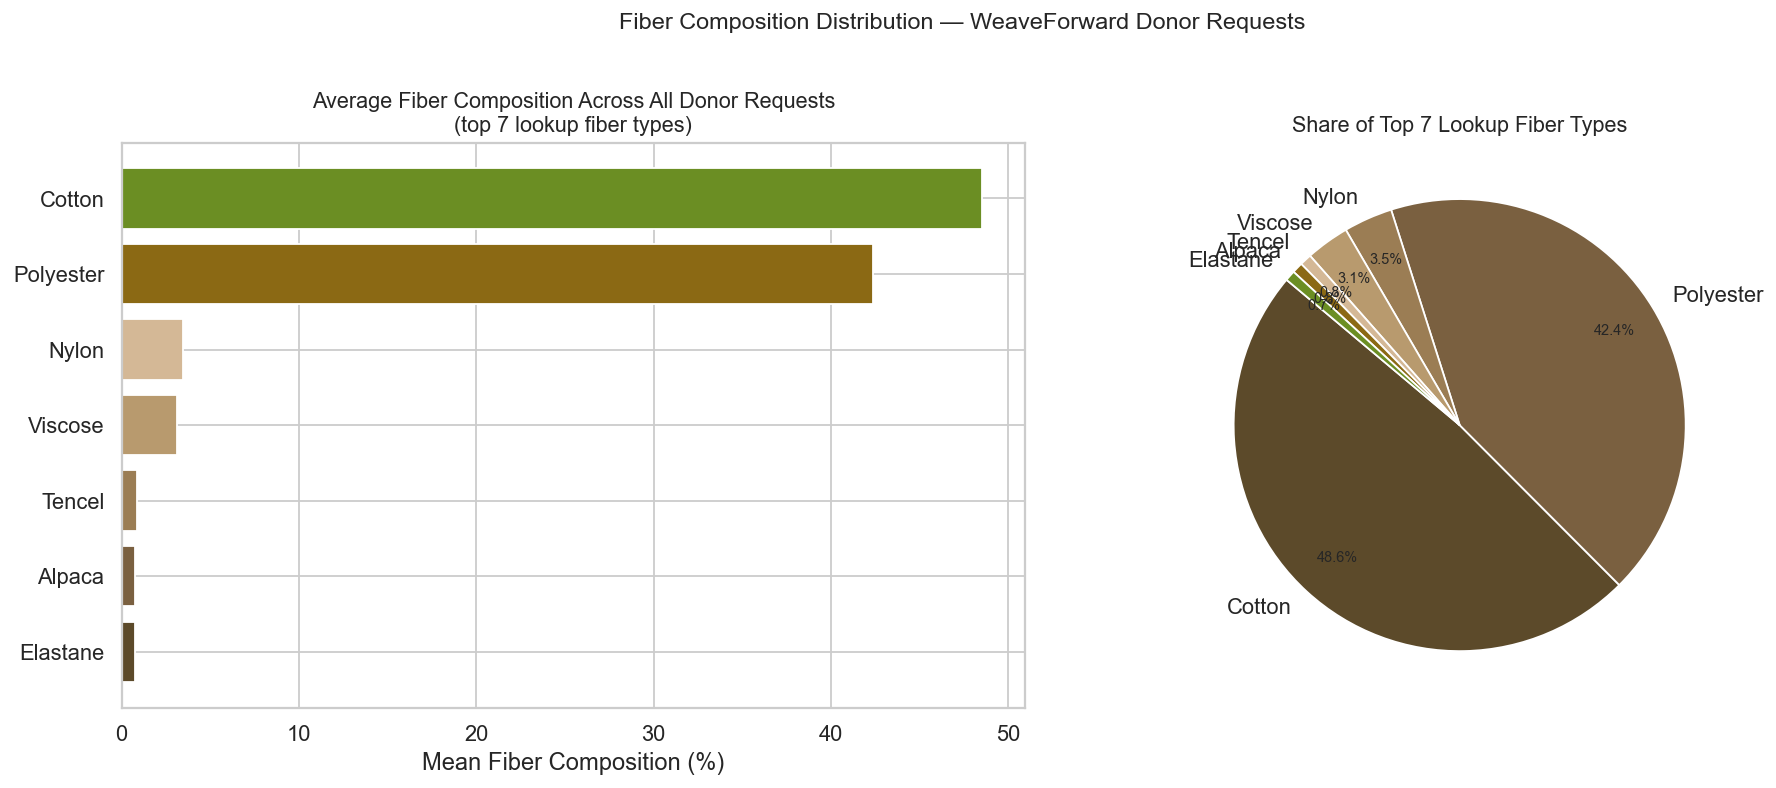

✓ 6-D saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/6D_fiber_distribution.png


In [ ]:
# ── 6-D  Fiber composition distribution — dominant fiber types ────────────
# Clamped to the lookup-fiber vocab; counts never exceed len(PCT_COLS).
_bar_n = min(12, len(PCT_COLS))

fiber_pct_mean = (df_feat[PCT_COLS]
                  .mean()
                  .sort_values(ascending=False)
                  .head(_bar_n))
labels = [c.replace("pct_", "").capitalize() for c in fiber_pct_mean.index]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(labels[::-1], fiber_pct_mean.values[::-1],
               color=sns.color_palette(EARTH, _bar_n))

# Annotate each bar with its exact mean value
for bar, val in zip(bars, fiber_pct_mean.values[::-1]):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2,
            f"{val:.1%}", va="center", fontsize=9, color="#4a2f1a")

ax.set_xlabel("Mean Fiber Composition (%)")
ax.set_title(f"Average Fiber Composition Across All Donor Requests\n"
             f"(top {_bar_n} lookup fiber types)", fontsize=13)
ax.set_xlim(0, fiber_pct_mean.values.max() * 1.2)
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.savefig(viz_path("6D_fiber_distribution"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-D saved → {viz_path('6D_fiber_distribution')}")


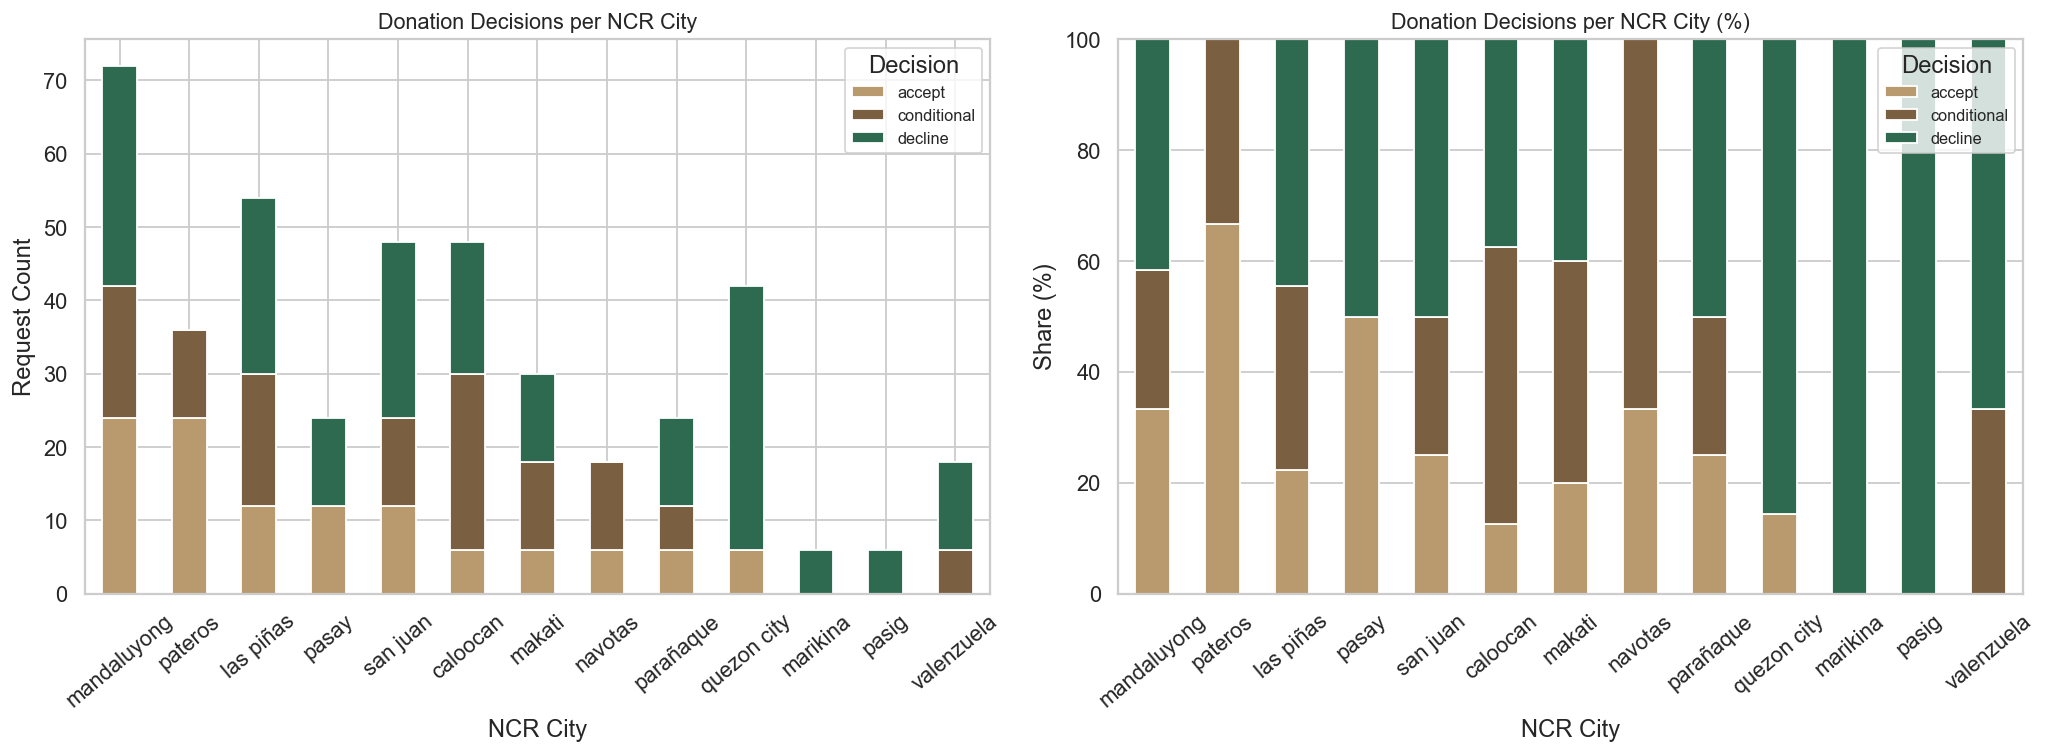

✓ 6-E saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/6E_decision_by_city.png


In [109]:
# ── 6-E  Donation decision by NCR city — stacked bar ─────────────────────
city_decision = (df_feat
                 .groupby(["ncr_city", "donation_decision"])
                 .size()
                 .unstack(fill_value=0)
                 .reindex(columns=["accept", "conditional", "decline"])
                 .sort_values("accept", ascending=False))

city_decision_pct = city_decision.div(city_decision.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
city_decision.plot(kind="bar", ax=axes[0], stacked=True,
                   color=[EARTH[3], EARTH[1], EARTH[8]])
axes[0].set_title("Donation Decisions per NCR City", fontsize=12)
axes[0].set_xlabel("NCR City"); axes[0].set_ylabel("Request Count")
axes[0].tick_params(axis="x", rotation=40)
axes[0].legend(title="Decision", fontsize=9)

# Percentage
city_decision_pct.plot(kind="bar", ax=axes[1], stacked=True,
                       color=[EARTH[3], EARTH[1], EARTH[8]])
axes[1].set_title("Donation Decisions per NCR City (%)", fontsize=12)
axes[1].set_xlabel("NCR City"); axes[1].set_ylabel("Share (%)")
axes[1].tick_params(axis="x", rotation=40)
axes[1].legend(title="Decision", fontsize=9)

plt.tight_layout()
plt.savefig(viz_path("6E_decision_by_city"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-E saved → {viz_path('6E_decision_by_city')}")


---
## 7 · Fiber–Artisan Match Model

Trains a **CatBoost binary classifier** to predict `is_match` (1 = donation satisfies artisan requirements, 0 = no match).

**Match criteria** (label generation in 5-B):
| Signal | Threshold | Feature used by model |
|---|---|---|
| `pct_target_fiber` ≥ 30 % | garment carries enough of artisan's fiber | `pct_target_fiber` (continuous) |
| `biodeg_score` ≥ `artisan_min_biodeg` | meets artisan's eco standard | `biodeg_score`, `artisan_min_biodeg` |
| `distance_km` ≤ `artisan_max_dist_km` | within collection radius | `distance_km`, `artisan_max_dist_km` |

The model receives continuous signals; the hard thresholds above are only used to generate the binary label from synthetic data. At inference time (WeaveForward Django API), the model scores each donation × artisan pair and returns `is_match` probabilities ranked by artisan proximity and fiber alignment.

Optuna performs 30-trial hyperparameter search with 3-fold stratified CV.


In [132]:
# ── 7-A  Train / test split ───────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train):,}  |  Test: {len(X_test):,}")
print("Label distribution — train:", dict(y_train.value_counts().sort_index()))
print("Label distribution — test :", dict(y_test.value_counts().sort_index()))


Train: 340  |  Test: 86
Label distribution — train: {0: np.int64(297), 1: np.int64(43)}
Label distribution — test : {0: np.int64(75), 1: np.int64(11)}


In [133]:
# ── 7-A-inspect  Split inspection ────────────────────────────────────────
print(f"Features  : {len(FEATURE_COLS)}  |  Target: '{TARGET}'")
print(f"Train size: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Test  size: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

print("\n── X_train — first 5 rows ───────────────────────────────────────────")
display(X_train.head())

print("\n── y_train — first 5 values ─────────────────────────────────────────")
display(y_train.head().to_frame())

print("\n── Class distribution (train) ───────────────────────────────────────")
_vc_train = y_train.value_counts().sort_index()
for lbl, cnt in _vc_train.items():
    print(f"  {TARGET}={lbl}: {cnt:>4}  ({cnt/len(y_train)*100:.1f}%)")

print("\n── Class distribution (test) ────────────────────────────────────────")
_vc_test = y_test.value_counts().sort_index()
for lbl, cnt in _vc_test.items():
    print(f"  {TARGET}={lbl}: {cnt:>4}  ({cnt/len(y_test)*100:.1f}%)")


Features  : 30  |  Target: 'is_match'
Train size: 340 samples × 30 features
Test  size: 86 samples × 30 features

── X_train — first 5 rows ───────────────────────────────────────────


,pct_alpaca,pct_cotton,pct_elastane,pct_nylon,pct_polyester,pct_tencel,pct_viscose,pct_bio_lookup,fs_bio_share,biodeg_score,...,clothing_type,source,most_dominant_fiber,dominant_fiber_lookup,matched_fiber,biodeg_tier,ncr_city,barangay,artisan_id,artisan_target_fibers_str
304,0.0,46.0,8.0,0.0,0.0,0.0,46.0,92.0,92.0,75.76,...,dress,philippine,cotton,cotton,cotton,medium,pasay,malibay,art-005,"alpaca,cotton"
22,0.0,35.0,0.0,0.0,65.0,0.0,0.0,35.0,35.0,37.40,...,dress,philippine,polyester,polyester,cotton,low,las piñas,almanza uno,art-001,"cotton,tencel"
154,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,92.00,...,dress,multinational,cotton,cotton,cotton,high,las piñas,almanza uno,art-003,"cotton,viscose,tencel"
380,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,92.00,...,shirt,multinational,cotton,cotton,nylon,high,las piñas,almanza uno,art-006,"nylon,polyester"
403,0.0,60.0,0.0,0.0,40.0,0.0,0.0,60.0,60.0,58.40,...,dress,philippine,cotton,cotton,polyester,medium,pateros,san pedro,art-006,"nylon,polyester"



── y_train — first 5 values ─────────────────────────────────────────


,is_match
304,0
22,0
154,0
380,0
403,0



── Class distribution (train) ───────────────────────────────────────
  is_match=0:  297  (87.4%)
  is_match=1:   43  (12.6%)

── Class distribution (test) ────────────────────────────────────────
  is_match=0:   75  (87.2%)
  is_match=1:   11  (12.8%)


In [118]:
# ── 7-B  Optuna hyperparameter search (30 trials, 3-fold stratified CV) ───
# Binary classification: Logloss + AUC eval metric

def objective(trial: optuna.Trial) -> float:
    params = {
        "iterations":          trial.suggest_int("iterations", 200, 800),
        "depth":               trial.suggest_int("depth", 4, 10),
        "learning_rate":       trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg":         trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count":        trial.suggest_int("border_count", 32, 255),
        "loss_function":       "Logloss",          # binary classification
        "eval_metric":         "AUC",
        "cat_features":        CAT_FEATURES,
        "random_seed":         42,
        "verbose":             False,
        "od_type":             "Iter",
        "od_wait":             40,
    }
    skf    = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for tr_i, va_i in skf.split(X_train, y_train):
        m = CatBoostClassifier(**params)
        m.fit(X_train.iloc[tr_i], y_train.iloc[tr_i],
              eval_set=(X_train.iloc[va_i], y_train.iloc[va_i]),
              use_best_model=True, verbose=False)
        scores.append(f1_score(y_train.iloc[va_i],
                               m.predict(X_train.iloc[va_i]),
                               average="binary"))
    return float(np.mean(scores))


study = optuna.create_study(direction="maximize",
                            study_name="weaveforward_fiber_match")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"\n✓ Best CV F1 (binary): {study.best_value:.4f}")
print("  Best params:", study.best_params)


  0%|          | 0/30 [00:00<?, ?it/s]


✓ Best CV F1 (binary): 0.9203
  Best params: {'iterations': 611, 'depth': 9, 'learning_rate': 0.225583594514379, 'l2_leaf_reg': 8.815991603050504, 'bagging_temperature': 0.4460860852219194, 'border_count': 159}


In [119]:
# ── 7-C  Final model training + save ─────────────────────────────────────
# plot=True renders a live Logloss + AUC chart directly in the cell output
# via CatBoost's built-in ipywidgets integration.
best_params = study.best_params | {
    "loss_function": "Logloss",
    "eval_metric":   "AUC",
    "cat_features":  CAT_FEATURES,
    "random_seed":   42,
    "verbose":       100,
}

model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=True)        # live Logloss + AUC chart updates every verbose step

MODEL_PATH = MODEL_DIR / "catboost_fiber_match.cbm"
model.save_model(str(MODEL_PATH))

META = {
    "trained_at":       datetime.utcnow().isoformat(),
    "notebook":         "fiber_recommendation_model.ipynb",
    "task":             "binary is_match classification (1=match, 0=no_match)",
    "target":           "is_match",
    "fiber_match_threshold": FIBER_MATCH_THRESHOLD,
    "feature_cols":     FEATURE_COLS,
    "cat_features":     CAT_FEATURES,
    "fiber_vocab":      FIBER_VOCAB,
    "fibers_of_interest": _FIBERS_OF_INTEREST,
    "biodeg_scores":    BIODEG_SCORES,
    "artisan_registry": ARTISAN_REGISTRY,
    "best_params":      study.best_params,
    "best_cv_f1":       study.best_value,
}
META_PATH = MODEL_DIR / "fiber_match_metadata.json"
with open(META_PATH, "w") as f:
    json.dump(META, f, indent=2)

print(f"✓ model saved   → {MODEL_PATH}")
print(f"✓ metadata      → {META_PATH}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9790483	best: 0.9790483 (0)	total: 5.24ms	remaining: 3.19s
100:	test: 1.0000000	best: 1.0000000 (5)	total: 840ms	remaining: 4.24s
200:	test: 1.0000000	best: 1.0000000 (5)	total: 1.64s	remaining: 3.35s
300:	test: 1.0000000	best: 1.0000000 (5)	total: 2.42s	remaining: 2.5s
400:	test: 1.0000000	best: 1.0000000 (5)	total: 3.2s	remaining: 1.68s
500:	test: 1.0000000	best: 1.0000000 (5)	total: 3.99s	remaining: 876ms
600:	test: 1.0000000	best: 1.0000000 (5)	total: 4.77s	remaining: 79.4ms
610:	test: 1.0000000	best: 1.0000000 (5)	total: 4.85s	remaining: 0us

bestTest = 1
bestIteration = 5

Shrink model to first 6 iterations.
✓ model saved   → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/models/catboost_fiber_match.cbm
✓ metadata      → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/models/fiber_match_metadata.json


---
## 8 · Evaluation — Fiber–Artisan Match Classifier

Binary metrics (Accuracy, F1, Precision, Recall, ROC-AUC) on the held-out test set, followed by confusion matrix, SHAP feature importance, and ranked prediction export for the WeaveForward Django API.


In [120]:
# ── 8-A  Prediction + classification report (binary) ─────────────────────
LABELS = ["is_match", "is_not_match"]   # 0, 1

y_pred = model.predict(X_test).flatten().astype(int)
y_prob = model.predict_proba(X_test)[:, 1]   # P(is_match=1)

metrics = {
    "Accuracy":             accuracy_score(y_test, y_pred),
    "F1 (binary)":          f1_score(y_test, y_pred, average="binary", zero_division=0),
    "F1 (macro)":           f1_score(y_test, y_pred, average="macro",  zero_division=0),
    "Precision":            precision_score(y_test, y_pred, average="binary", zero_division=0),
    "Recall":               recall_score(y_test, y_pred, average="binary",    zero_division=0),
    "ROC-AUC":              (roc_auc_score(y_test, y_prob)
                             if len(set(y_test)) > 1 else None),
}

print("=" * 52)
print("  WeaveForward — Fiber–Artisan Match Model")
print("=" * 52)
for k, v in metrics.items():
    if v is not None:
        print(f"  {k:<28} {v:.4f}")
    else:
        print(f"  {k:<28} N/A")
print()
print(classification_report(y_test, y_pred, target_names=LABELS, zero_division=0))


  WeaveForward — Fiber–Artisan Match Model
  Accuracy                     0.9767
  F1 (binary)                  0.9524
  F1 (macro)                   0.9685
  Precision                    1.0000
  Recall                       0.9091
  ROC-AUC                      1.0000

              precision    recall  f1-score   support

    is_match       0.97      1.00      0.98        64
is_not_match       1.00      0.91      0.95        22

    accuracy                           0.98        86
   macro avg       0.98      0.95      0.97        86
weighted avg       0.98      0.98      0.98        86



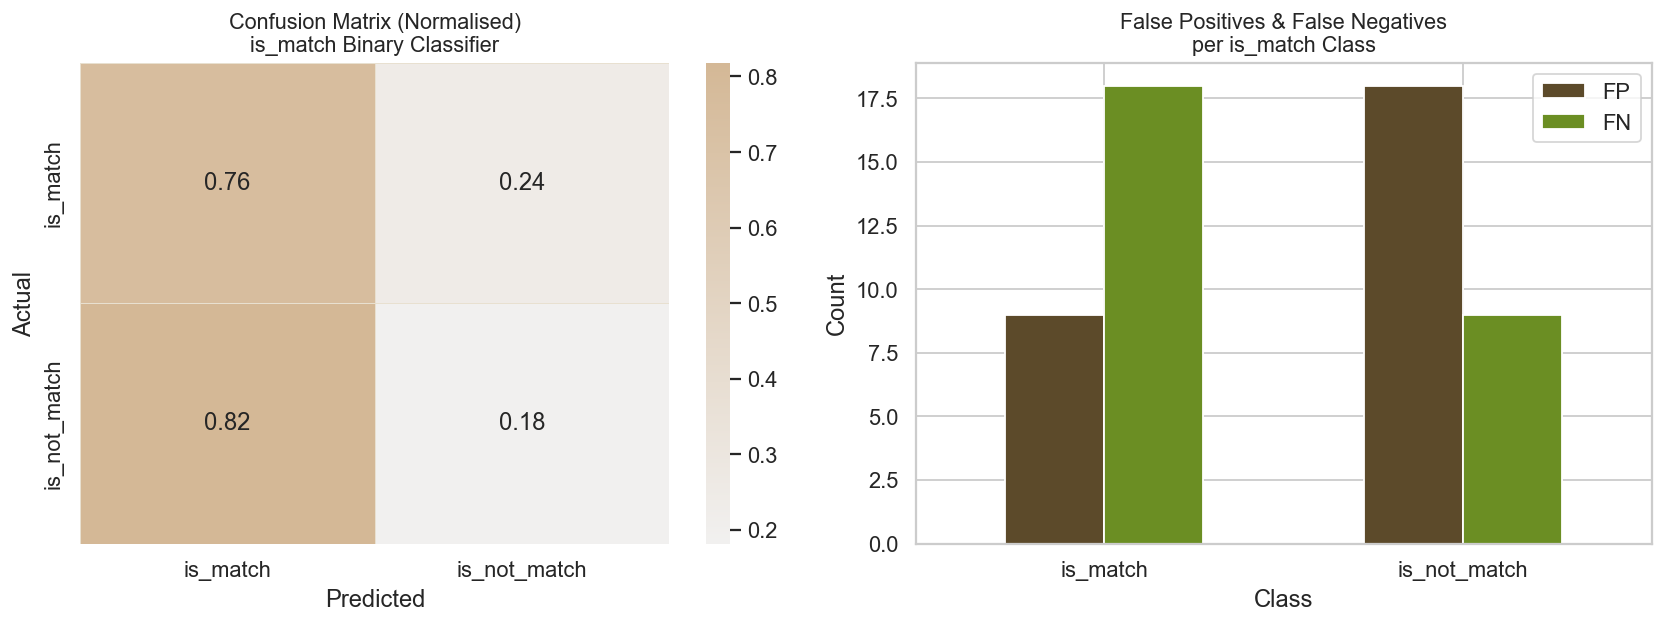

✓ 8-B saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/8B_confusion_fp_fn.png
FP/FN table:
               FP  FN
is_match       9  18
is_not_match  18   9


In [134]:
# ── 8-B  Confusion matrix + FP/FN earth-tone chart (binary) ─────────────
cm     = confusion_matrix(y_test, y_pred)
cm_std = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Normalised confusion matrix
earth_seq = sns.light_palette(EARTH[4], as_cmap=True)
sns.heatmap(cm_std, annot=True, fmt=".2f", cmap=earth_seq,
            xticklabels=LABELS, yticklabels=LABELS, ax=axes[0],
            linewidths=0.5, linecolor="#e8e0d0")
axes[0].set_title("Confusion Matrix (Normalised)\nis_match Binary Classifier", fontsize=12)
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

# FP / FN bar
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
err_df = pd.DataFrame({"FP": fp, "FN": fn}, index=LABELS)
err_df.plot(kind="bar", ax=axes[1], color=[EARTH[0], EARTH[6]], edgecolor="white",
            width=0.55)
axes[1].set_title("False Positives & False Negatives\nper is_match Class", fontsize=12)
axes[1].set_xlabel("Class"); axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig(viz_path("8B_confusion_fp_fn"), dpi=150)
plt.show()
print(f"✓ 8-B saved → {viz_path('8B_confusion_fp_fn')}")
print("FP/FN table:\n", err_df.to_string())


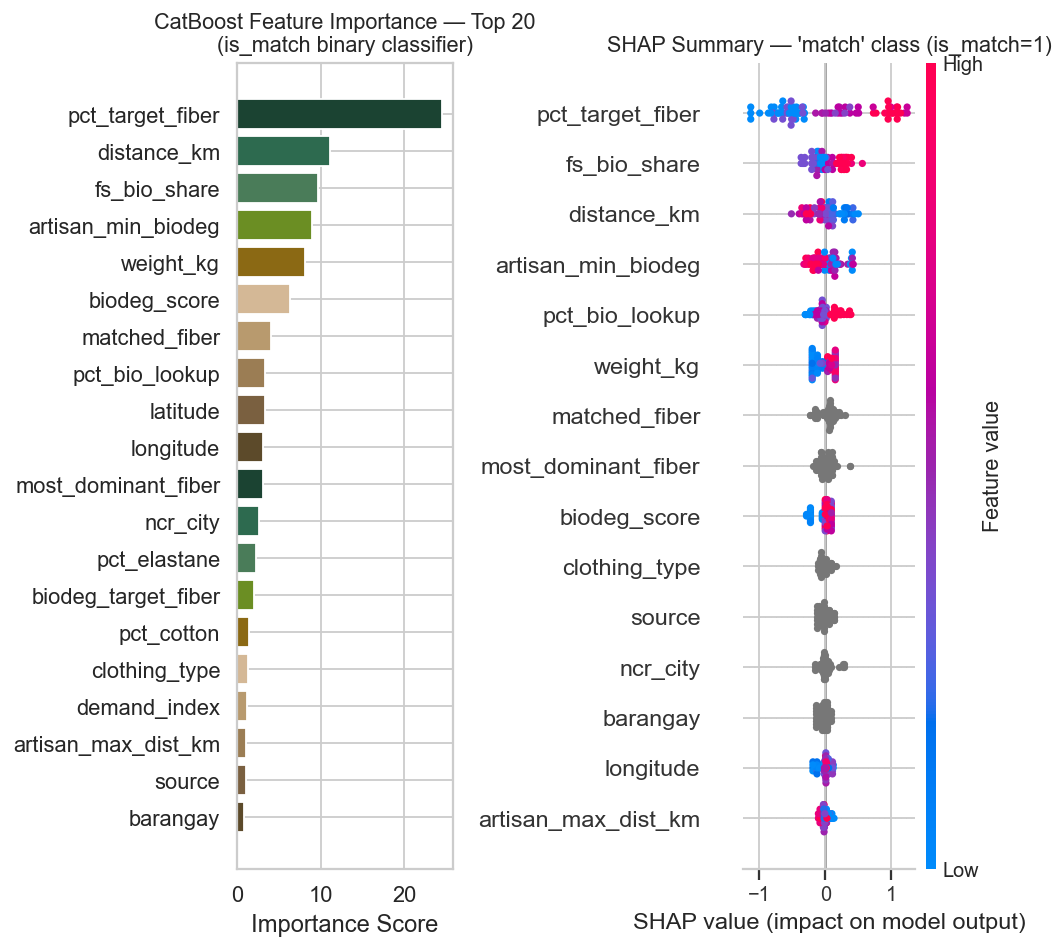

✓ 8-C saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/8C_feature_importance_shap.png

Top 10 features by importance:
pct_target_fiber      24.521444
distance_km           11.060799
fs_bio_share           9.617449
artisan_min_biodeg     8.926740
weight_kg              8.067927
biodeg_score           6.353130
matched_fiber          4.053749
pct_bio_lookup         3.353425
latitude               3.331487
longitude              3.119938


In [135]:
# ── 8-C  Feature importance + SHAP (binary is_match) ─────────────────────
feat_imp = pd.Series(model.get_feature_importance(),
                     index=FEATURE_COLS).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(17, 6))

# Top-20 importance bar
top_imp = feat_imp.head(20)
axes[0].barh(top_imp.index[::-1], top_imp.values[::-1],
             color=sns.color_palette(EARTH, 20))
axes[0].set_title("CatBoost Feature Importance — Top 20\n(is_match binary classifier)",
                  fontsize=12)
axes[0].set_xlabel("Importance Score")

# SHAP summary — class 1 (is_match=1, "match")
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# CatBoost binary returns 2-element list or a single array depending on version
_sv = shap_values[1] if isinstance(shap_values, list) else shap_values

shap.summary_plot(_sv, X_test,
                  feature_names=FEATURE_COLS,
                  show=False, plot_type="dot", max_display=15)
plt.title("SHAP Summary — 'match' class (is_match=1)", fontsize=12)

plt.tight_layout()
plt.savefig(viz_path("8C_feature_importance_shap"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 8-C saved → {viz_path('8C_feature_importance_shap')}")
print("\nTop 10 features by importance:")
print(feat_imp.head(10).to_string())


In [140]:
# ── 8-D  Donor requests routed TO each artisan business (test set) ────────
# Results here are MODEL predictions (y_pred = model.predict(X_test)).
# "predicted == 1" means the model decided to route that donor request to
# that artisan.  The TP/FP split uses y_test (ground truth) only to
# evaluate prediction quality — in production only "predicted" exists.

# ── Build scored test-set frame ───────────────────────────────────────────
_test_idx = X_test.index
_scored   = df_feat.loc[_test_idx].copy()
_scored["match_prob"] = y_prob          # model probability score
_scored["predicted"]  = y_pred          # model routing decision (1 = route)
_scored["actual"]     = y_test.values   # ground truth (eval only)

# ── Donor-request columns (what the artisan sees about the incoming item) ──
_donor_cols = [
    "donation_id", "brand", "clothing_type", "ncr_city", "barangay",
    "matched_fiber", "pct_target_fiber", "biodeg_score",
    "distance_km", "weight_kg", "match_prob",
]
_donor_cols = [c for c in _donor_cols if c in _scored.columns]

# ── Model-predicted routes ────────────────────────────────────────────────
_matches = _scored[_scored["predicted"] == 1].copy()
_tp      = _matches[_matches["actual"] == 1]   # correctly routed
_fp      = _matches[_matches["actual"] == 0]   # incorrectly routed

print("=" * 72)
print("  DONOR REQUESTS ROUTED TO ARTISAN BUSINESSES  (MODEL PREDICTIONS)")
print(f"  Threshold: {FIBER_MATCH_THRESHOLD}%  |  "
      f"Test rows: {len(_scored)}  |  "
      f"Model-routed requests: {len(_matches)}")
print("=" * 72)

# ── Per-artisan inbox — correctly routed ─────────────────────────────────
print("\n-- Correctly routed (TP) — requests the model routes AND ground truth confirms\n")
for artisan_name, grp in _tp.groupby("artisan_name"):
    accepted_fibers = grp["artisan_target_fibers_str"].iloc[0]
    print(f"  {artisan_name}  (accepts: {accepted_fibers})"
          f"  <--  {len(grp)} incoming request(s)")
    display(
        grp[_donor_cols]
        .sort_values("match_prob", ascending=False)
        .reset_index(drop=True)
    )
    print()

if len(_fp):
    print(f"\n-- Incorrectly routed (FP) — {len(_fp)} request(s) model routed but should not have\n")
    for artisan_name, grp in _fp.groupby("artisan_name"):
        accepted_fibers = grp["artisan_target_fibers_str"].iloc[0]
        print(f"  {artisan_name}  (accepts: {accepted_fibers})"
              f"  <--  {len(grp)} misrouted request(s)")
        display(
            grp[_donor_cols]
            .sort_values("match_prob", ascending=False)
            .reset_index(drop=True)
        )
        print()
else:
    print("\n-- Incorrectly routed (FP): 0  — model made no incorrect routing decisions")


  DONOR REQUESTS ROUTED TO ARTISAN BUSINESSES  (MODEL PREDICTIONS)
  Threshold: 85.0%  |  Test rows: 86  |  Model-routed requests: 20

-- Correctly routed (TP) — requests the model routes AND ground truth confirms

  Diliman Fiber Collective  (accepts: tencel,viscose)  <--  1 incoming request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-CF956D36,penshoppe,dress,mandaluyong,wack-wack greenhills,viscose,100.0,72.0,11.092,0.293,0.727916



  Makati Upcycle Studio  (accepts: cotton,viscose,tencel)  <--  1 incoming request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-ABDA0E4A,penshoppe,dress,pateros,san pedro,cotton,98.0,90.24,4.681,0.516,0.74564




-- Incorrectly routed (FP) — 18 request(s) model routed but should not have

  Diliman Fiber Collective  (accepts: tencel,viscose)  <--  2 misrouted request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-20D46008,penshoppe,dress,caloocan,bagong silang,tencel,0.0,8.00,10.071,0.333,0.675511
1,DNR-CF956D36,columbia,jacket,mandaluyong,wack-wack greenhills,tencel,0.0,9.11,11.092,1.418,0.541227



  Habi Weaves Ermita  (accepts: cotton,tencel)  <--  5 misrouted request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-F72D14AE,everlane,dress,caloocan,bagong silang,cotton,0.0,4.0,9.145,0.369,0.879384
1,DNR-53F848DE,penshoppe,dress,mandaluyong,wack-wack greenhills,cotton,35.0,37.4,4.398,0.491,0.859743
2,DNR-246317FF,penshoppe,dress,makati,bel-air,cotton,35.0,37.4,6.490,0.208,0.813727
3,DNR-000E3C8C,penshoppe,dress,pateros,san pedro,cotton,60.0,58.4,11.860,0.366,0.694745
4,DNR-438B31FE,penshoppe,dress,las piñas,almanza uno,cotton,35.0,37.4,15.016,0.249,0.580717



  Makati Upcycle Studio  (accepts: cotton,viscose,tencel)  <--  2 misrouted request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-F0746B0F,penshoppe,dress,valenzuela,karuhatan,cotton,0.0,8.0,16.936,0.524,0.712308
1,DNR-E35A3A9D,penshoppe,dress,quezon city,diliman,cotton,35.0,37.4,11.757,0.468,0.695627



  Marikina Heritage Weavers  (accepts: alpaca,cotton)  <--  2 misrouted request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-AC5459A7,penshoppe,dress,san juan,greenhills,cotton,55.0,54.2,10.895,0.303,0.711369
1,DNR-7446DFF5,penshoppe,dress,las piñas,almanza uno,cotton,50.0,50.0,22.825,0.461,0.559747



  Pasig Natural Threads  (accepts: viscose,cotton)  <--  2 misrouted request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-AC5459A7,penshoppe,dress,san juan,greenhills,cotton,55.0,54.2,8.127,0.303,0.812038
1,DNR-F0746B0F,penshoppe,dress,valenzuela,karuhatan,cotton,60.0,58.4,18.885,0.330,0.712308



  Taguig EcoFabric Lab  (accepts: nylon,polyester)  <--  5 misrouted request(s)


,donation_id,brand,clothing_type,ncr_city,barangay,matched_fiber,pct_target_fiber,biodeg_score,distance_km,weight_kg,match_prob
0,DNR-B0F2C0C2,penshoppe,dress,mandaluyong,wack-wack greenhills,polyester,95.0,7.8,9.590,0.232,0.795548
1,DNR-CF956D36,penshoppe,dress,mandaluyong,wack-wack greenhills,polyester,40.0,58.4,7.228,0.539,0.786412
2,DNR-B0F2C0C2,penshoppe,dress,mandaluyong,wack-wack greenhills,nylon,0.0,92.0,9.590,0.453,0.770816
3,DNR-B2F30A88,mango,t-shirt,quezon city,diliman,nylon,0.0,92.0,15.269,0.245,0.709845
4,DNR-44925C2A,penshoppe,dress,parañaque,bf homes,polyester,65.0,37.4,9.303,0.421,0.589053
